### Requirements

In [2]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 35.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 63.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 71.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 3.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 42.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 81.6 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.8/346.8 KB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 KB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
import wandb
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.datasets import mnist

2025-03-10 19:28:58.798940: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-10 19:28:58.800893: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-10 19:28:58.806638: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-10 19:28:58.819568: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741634938.841956   17767 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741634938.84

In [4]:
wandb.login(key="843913992a9025996973825be4ad46e4636d0610")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ubuntu/.netrc
wandb: Currently logged in as: cs24m021 (cs24m021-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
PROJECT = "DA6401_DL_Assignment1"
ENTITY = "karan"
SWEEPCOUNT = 250

### Loading Data

In [6]:
# for question 1-8
(train_img, train_labels), (test_img, test_labels) = fashion_mnist.load_data()
target_classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# for question 10
(mnist_train, mnist_train_label), (mnist_test, mnist_test_label) = mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step 
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step 


## Question 1: Plot one sample per class

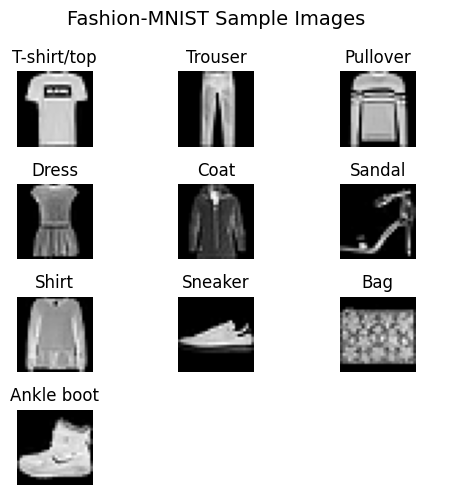

In [51]:
wandb.init(project=PROJECT, name="Question_1")  
sample = []
for id in range(10):
    index = np.where(train_labels == id)[0][0]  # first occurrence of each class
    sample.append(train_img[index])  # corresponding image to the sample list

fig, axes = plt.subplots(4, 3, figsize=(5, 5))  
fig.suptitle("Fashion-MNIST Sample Images", fontsize=14)  

for i, ax in enumerate(axes.flat):
    if i < len(sample):
        ax.imshow(sample[i], cmap='gray')  # display the image in grayscale
        ax.set_title(target_classes[i]) 
        ax.axis("off") 
    else:
        ax.axis("off")  

plt.tight_layout() 
wandb.log({"Sample_Images": wandb.Image(plt)})  # logging to wandb
plt.show()
wandb.finish(); 

### Activation Functions

In [8]:
class Activation_Functions:
    def __init__(self):
        self.activation_functions = {
            "tanh": self.tanh,
            "sigmoid": self.sigmoid,
            "ReLU": self.ReLU,
            "softmax": self.softmax,
            "identity": self.identity
        }

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # numerical stability
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)  # softmax probabilities
        
    def sigmoid(self, x):
        result = np.zeros_like(x)
        result[x >= 0] = 1 / (1 + np.exp(-x[x >= 0]))  # for positive values
        result[x < 0] = np.exp(x[x < 0]) / (1 + np.exp(x[x < 0]))  # for negative values
        return result

    def ReLU(self, x):
        return np.maximum(0, x)  # ReLU activation

    def tanh(self, x):
        return np.tanh(x)  # hyperbolic tangent activation

    def identity(self, x):
        return x  # identity function

    def activation(self, x, fun):
        activation_function = self.activation_functions.get(fun)
        if activation_function:
            return activation_function(x)
        else:
            raise ValueError(f"Activation function '{fun}' is not supported.")

### Loss Functions

In [9]:
class Loss_Function:
    def __init__(self):
        pass

    def compute_loss(self, y_true, y_pred, loss_function="cross_entropy"):
        if loss_function == "cross_entropy":
            epsilon = 1e-15
            y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # clip to avoid log(0)
            return np.mean(-np.sum(y_true * np.log(y_pred), axis=1))  # cross-entropy loss
        if loss_function == "mean_squared_error":
            return 0.5 * np.mean(np.sum((y_true - y_pred) ** 2, axis=1))  # MSE loss

    def last_output_derivative(self, y_pred, y_true, activation_derivative, loss_function="cross_entropy"):
        if loss_function == "mean_squared_error":
            return (y_pred - y_true) * activation_derivative / len(y_true)  # MSE derivative
        if loss_function == "cross_entropy":
            return -(y_true - y_pred)  # cross-entropy derivative

### Derivatioves

In [10]:
class Derivatives:
    def __init__(self):
        self.activation = Activation_Functions()
        self.derivative_functions = {
            "sigmoid": self.sigmoid_derivative,
            "tanh": self.tanh_derivative,
            "ReLU": self.ReLU_derivative,
            "softmax": self.softmax_derivative,
            "identity": self.identity_derivative
        }

    def sigmoid_derivative(self, x):
        k = self.activation.sigmoid(x)
        return k * (1 - k)  # derivative of sigmoid

    def softmax_derivative(self, x):
        k = self.activation.softmax(x)
        return k * (1 - k)  # derivative of softmax

    def tanh_derivative(self, x):
        k = self.activation.tanh(x)
        return 1 - k ** 2  # derivative of tanh

    def ReLU_derivative(self, x):
        x[x > 0] = 1  # derivative is 1 for x > 0
        x[x <= 0] = 0  # derivative is 0 for x <= 0
        return x

    def identity_derivative(self, x):
        return np.ones_like(x)  # derivative of identity is 1

    def derivatives(self, x, activation_function):
        derivative_function = self.derivative_functions.get(activation_function)
        if derivative_function:
            return derivative_function(x)
        else:
            raise ValueError(f"Derivative for activation function '{activation_function}' is not supported.")

## Question 2

In [11]:
def forward_pass(x, weights, biases, activation, layer_sizes):
    activation_func = Activation_Functions()
    outputs, activations = {}, {}
    outputs[0] = x  # input layer
    
    num_layers = len(layer_sizes)
    
    for layer in range(1, num_layers - 1):
        activations[layer] = np.dot(outputs[layer - 1], weights[layer]) + biases[layer]  # linear transformation
        outputs[layer] = activation_func.activation(activations[layer], fun=activation)  # apply activation
    
    activations[num_layers - 1] = np.dot(outputs[num_layers - 2], weights[num_layers - 1]) + biases[num_layers - 1]
    outputs[num_layers - 1] = activation_func.activation(activations[num_layers - 1], fun="softmax")  # softmax for output layer
    
    return outputs[num_layers - 1]  # final output

def Network_Q2(data, activation, input_size, layers, output_size):
    weights, biases = {}, {}
    layer_sizes = [input_size] + layers + [output_size]  # define layer sizes
    predicted_probs = []
    
    for layer in range(1, len(layer_sizes)):
        weights[layer] = np.random.randn(layer_sizes[layer - 1], layer_sizes[layer])  # initialize weights
        biases[layer] = np.random.randn(1, layer_sizes[layer])  # initialize biases
    
    for sample in data:
        x = sample.reshape(1, -1) / 255.0  # normalize input
        y_pred = forward_pass(x, weights, biases, activation, layer_sizes)  # forward pass
        predicted_probs.append(y_pred)  # store predictions
    
    return predicted_probs  # return all predictions

In [12]:
y_pred_Q2 = Network_Q2(train_img, "sigmoid", 784, [32, 32, 32], 10)  
print(np.array(y_pred_Q2[:5]).round(6))  # print first 5 predictions

[[[1.17250e-02 2.72300e-02 1.21100e-03 5.57880e-02 8.69800e-02
   7.82199e-01 3.15600e-03 2.66560e-02 2.38600e-03 2.66900e-03]]

 [[7.55920e-02 7.82340e-02 1.19300e-03 3.16612e-01 2.12596e-01
   2.85222e-01 5.74600e-03 1.22360e-02 3.82600e-03 8.74300e-03]]

 [[9.62940e-02 1.96890e-02 1.26600e-03 5.35780e-02 4.44051e-01
   3.52069e-01 1.96590e-02 6.00300e-03 7.98000e-04 6.59300e-03]]

 [[1.19331e-01 6.60670e-02 4.68000e-04 6.86380e-02 4.67997e-01
   2.56594e-01 7.13500e-03 7.14000e-03 2.27900e-03 4.35200e-03]]

 [[5.33150e-02 8.15390e-02 1.64200e-03 1.47451e-01 2.19385e-01
   4.68893e-01 1.10290e-02 9.51000e-03 2.33900e-03 4.89800e-03]]]


### Optimizers

In [11]:
class Optimizer:
    def __init__(self, model, config):
        self.model = model  
        self.learning_rate = config["eta"]  
        self.decay = config["weight_decay"]  
        self.optim_type = config["optimizer"]  
        self.momentum = config["momentum"] 
        self.beta1 = config["beta1"] 
        self.beta2 = config["beta2"]  
        self.epsilon_val = config["epsilon"]
        self.optimization_methods = {
            "sgd": self.stochastic_gradient_descent,
            "momentum": self.momentum_gradient_descent,
            "nesterov": self.nesterov_gradient_descent,
            "nag": self.nesterov_gradient_descent,
            "rmsprop": self.rmsprop,
            "adam": self.adam,
            "nadam": self.nadam
        }

    def update_parameters(self, timestep):
        optimization_function = self.optimization_methods.get(self.optim_type)
        
        if optimization_function:
            if self.optim_type in ["adam", "nadam"]:
                optimization_function(timestep)
            else:
                optimization_function()
        else:
            raise ValueError(f"Optimization method '{self.optim_type}' is not supported.")

    def stochastic_gradient_descent(self):
        param_layers = self.model.weights.keys()
        for l in param_layers:
            reg_term = self.model.weights[l] * self.decay  # weight decay
            self.model.grad_weights[l] += reg_term
            bias_update = self.learning_rate * self.model.grad_biases[l]  # bias update
            self.model.biases[l] -= bias_update
            weight_update = self.learning_rate * self.model.grad_weights[l]  # weight update
            self.model.weights[l] -= weight_update

    def momentum_gradient_descent(self):
        for layer in self.model.weights.keys():
            self.model.grad_weights[layer] += self.decay * self.model.weights[layer]  # weight decay
            prev_momentum_w = self.momentum * self.model.m_weights[layer]
            new_momentum_w = prev_momentum_w + self.learning_rate * self.model.grad_weights[layer]  # momentum update
            prev_momentum_b = self.momentum * self.model.m_biases[layer]
            new_momentum_b = prev_momentum_b + self.learning_rate * self.model.grad_biases[layer]
            self.model.m_weights[layer] = new_momentum_w
            self.model.m_biases[layer] = new_momentum_b
            self.model.weights[layer] -= new_momentum_w
            self.model.biases[layer] -= new_momentum_b

    def nesterov_gradient_descent(self):
        for l in self.model.weights.keys():
            momentum_w = self.momentum * self.model.m_weights[l]  # momentum term
            lookahead_w = self.model.weights[l] - momentum_w  # lookahead step
            lookahead_b = self.model.biases[l] - self.momentum * self.model.m_biases[l]
            self.model.grad_weights[l] += lookahead_w * self.decay  # weight decay
            grad_w = self.model.grad_weights[l]
            grad_b = self.model.grad_biases[l]
            new_m_w = self.momentum * self.model.m_weights[l] - self.learning_rate * grad_w  # update momentum
            new_m_b = self.momentum * self.model.m_biases[l] - self.learning_rate * grad_b
            self.model.weights[l] += new_m_w
            self.model.biases[l] += new_m_b
            self.model.m_weights[l] = new_m_w
            self.model.m_biases[l] = new_m_b

    def rmsprop(self):
        for layer in self.model.weights.keys():
            current_grad_w = self.model.grad_weights[layer] + self.model.weights[layer] * self.decay  # weight decay
            current_grad_b = self.model.grad_biases[layer]
            self.model.v_weights[layer] = self.beta2*self.model.v_weights[layer] + (1-self.beta2)*(current_grad_w**2)  # velocity update
            self.model.v_biases[layer] = self.beta2*self.model.v_biases[layer] + (1-self.beta2)*(current_grad_b**2)
            epsilon = 1e-8 if self.epsilon_val < 1e-8 else self.epsilon_val  # numerical stability
            self.model.weights[layer] -= (current_grad_w * self.learning_rate) / (np.sqrt(self.model.v_weights[layer]) + epsilon)  # update weights
            self.model.biases[layer] -= (current_grad_b * self.learning_rate) / (np.sqrt(self.model.v_biases[layer]) + epsilon)

    def adam(self, step):
        for l in self.model.weights.keys():
            decay_contribution = self.decay * self.model.weights[l] # weight decay
            self.model.grad_weights[l] += decay_contribution
            
            grad_w = np.clip(self.model.grad_weights[l], -1e3, 1e3)
            grad_b = np.clip(self.model.grad_biases[l], -1e3, 1e3)
            
            m_w = self.beta1 * self.model.m_weights[l] + (1 - self.beta1) * grad_w # momentum update with numerical stability
            m_b = self.beta1 * self.model.m_biases[l] + (1 - self.beta1) * grad_b
            
            v_w = self.beta2 * self.model.v_weights[l] + (1 - self.beta2) * (grad_w**2 + 1e-8)
            v_b = self.beta2 * self.model.v_biases[l] + (1 - self.beta2) * (grad_b**2 + 1e-8)
            
            self.model.m_weights[l], self.model.v_weights[l] = m_w, v_w
            self.model.m_biases[l], self.model.v_biases[l] = m_b, v_b
            
            beta1_t = max(self.beta1**step, 1e-8)
            beta2_t = max(self.beta2**step, 1e-8)
            mw_corrected = m_w / (1 - beta1_t + 1e-8)
            vw_corrected = v_w / (1 - beta2_t + 1e-8)
            mb_corrected = m_b / (1 - beta1_t + 1e-8)
            vb_corrected = v_b / (1 - beta2_t + 1e-8)
            
            weight_update = self.learning_rate * mw_corrected / (np.sqrt(vw_corrected) + self.epsilon_val)
            bias_update = self.learning_rate * mb_corrected / (np.sqrt(vb_corrected) + self.epsilon_val)
            
            self.model.weights[l] -= np.clip(weight_update, -1e3, 1e3)
            self.model.biases[l] -= np.clip(bias_update, -1e3, 1e3)

    def nadam(self, step):
        for l in self.model.weights.keys():
            self.model.grad_weights[l] += self.model.weights[l] * self.decay
            grad_w = np.clip(self.model.grad_weights[l], -1e3, 1e3)
            grad_b = np.clip(self.model.grad_biases[l], -1e3, 1e3)
            
            m_w_new = self.beta1 * self.model.m_weights[l] + (1-self.beta1)*grad_w
            m_b_new = self.beta1 * self.model.m_biases[l] + (1-self.beta1)*grad_b

            v_w_new = self.beta2 * self.model.v_weights[l] + (1-self.beta2)*(grad_w**2 + 1e-8)
            v_b_new = self.beta2 * self.model.v_biases[l] + (1-self.beta2)*(grad_b**2 + 1e-8)
            
            beta1_t = max(self.beta1**step, 1e-8)
            beta2_t = max(self.beta2**step, 1e-8)
            mw_hat = m_w_new / (1 - beta1_t + 1e-8)
            vw_hat = v_w_new / (1 - beta2_t + 1e-8)
            mb_hat = m_b_new / (1 - beta1_t + 1e-8)
            vb_hat = v_b_new / (1 - beta2_t + 1e-8)
            
            nesterov_w = self.beta1 * mw_hat + (1-self.beta1)*grad_w/(1 - beta1_t + 1e-8)
            nesterov_b = self.beta1 * mb_hat + (1-self.beta1)*grad_b/(1 - beta1_t + 1e-8)
            
            weight_update = self.learning_rate * nesterov_w / (np.sqrt(vw_hat) + self.epsilon_val)
            bias_update = self.learning_rate * nesterov_b / (np.sqrt(vb_hat) + self.epsilon_val)
            
            self.model.weights[l] -= np.clip(weight_update, -1e3, 1e3)
            self.model.biases[l] -= np.clip(bias_update, -1e3, 1e3)
            
            self.model.m_weights[l], self.model.v_weights[l] = m_w_new, v_w_new
            self.model.m_biases[l], self.model.v_biases[l] = m_b_new, v_b_new

### Final Neural Network Functionalities

In [12]:
class Neural_Network:
    def __init__(self, config, log=1, console=1):
        self.weights, self.biases, self.a, self.h = {}, {}, {}, {}
        self.grad_weights, self.grad_biases, self.m_weights, self.m_biases = {}, {}, {}, {}
        self.v_weights, self.v_biases = {}, {}

        self.activation_function = config["activation_function"]
        self.loss_function = config["loss_function"]
        self.initialization = config["init"]
        self.hidden_layers = config["hidden_layers"]
        self.hidden_layer_sizes = config["hidden_layer_sizes"]
        self.dataset = config["dataset"]
        self.wan_log, self.console_log = log, console
        self.loss = Loss_Function()
        self.act = Activation_Functions()
        self.derivative = Derivatives()

        (train_img, train_lbl), (test_img, test_lbl) = self.load_dataset()
        train_img, val_img, train_lbl, val_lbl = train_test_split(train_img, train_lbl, test_size=0.1, random_state=41)

        self.input, self.y_true = self.preprocess_data(train_img, train_lbl)  # preprocess training data
        self.val_img, self.val_true = self.preprocess_data(val_img, val_lbl)  # preprocess validation data
        self.test_img, self.test_true = self.preprocess_data(test_img, test_lbl)  # preprocess test data
        self.layers = [self.input.shape[1]] + [self.hidden_layer_sizes] * self.hidden_layers + [10]  
        
        self.initialize_parameters()  # initialize weights and biases

    def load_dataset(self):
        if self.dataset == 'fashion_mnist':
            return (train_img, train_labels), (test_img, test_labels)
        if self.dataset == 'mnist':
            return (mnist_train, mnist_train_label), (mnist_test, mnist_test_label)
        else:
            raise ValueError("Unknown dataset")

    def preprocess_data(self, images, labels):
        return images.reshape(images.shape[0], -1) / 255.0 , labels  # normalize and reshape data

    def initialize_parameters(self):
        for layer in range(1, len(self.layers)):
            self.v_weights[layer] = np.zeros((self.layers[layer-1], self.layers[layer]))  # initialize velocity for weights
            self.v_biases[layer] = np.zeros((1, self.layers[layer]))  # initialize velocity for biases
            
            self.m_weights[layer] = np.zeros((self.layers[layer-1], self.layers[layer]))  # initialize momentum for weights
            self.m_biases[layer] = np.zeros((1, self.layers[layer]))  # initialize momentum for biases
            
            if self.initialization == "random":
                self.weights[layer] = np.random.normal(0, 1, (self.layers[layer-1], self.layers[layer]))
                self.biases[layer] = np.random.normal(0, 1, (1, self.layers[layer]))
            elif self.initialization == "Xavier":
                scale_w = np.sqrt(2.0 / (self.layers[layer-1] + self.layers[layer]))
                scale_b = np.sqrt(2.0 / (1 + self.layers[layer]))
                self.weights[layer] = np.random.normal(0, scale_w, (self.layers[layer-1], self.layers[layer]))
                self.biases[layer] = np.random.normal(0, scale_b, (1, self.layers[layer]))

    def forward_propagation(self, x):
        self.h[0] = x
        num_layers = len(self.layers) - 1
    
        for layer in range(1, num_layers):
            linear_output = self.h[layer-1] @ self.weights[layer]
            self.a[layer] = linear_output + self.biases[layer]   # linear transformation
            self.h[layer] = self.act.activation(self.a[layer], self.activation_function)
    
        final_linear_output = self.h[num_layers-1] @ self.weights[num_layers]
        self.a[num_layers] = final_linear_output + self.biases[num_layers]
        self.h[num_layers] = self.act.activation(self.a[num_layers], "softmax") # softmax for output layer
    
        output = self.h[num_layers]
        return output

    def backward_propagation(self, x, y_true, y_hat): 
        output_layer_index = len(self.layers) - 1  # softmax derivative for output layer  
        softmax_grad = self.derivative.derivatives(self.a[output_layer_index], "softmax")  
        error = self.loss.last_output_derivative(y_hat, y_true, softmax_grad, self.loss_function)  
    
        # for hidden layers
        for current_layer in reversed(range(2, len(self.layers))):  
            prev_hidden = self.h[current_layer - 1]  
    
            self.grad_weights[current_layer] = prev_hidden.T @ error  
            self.grad_biases[current_layer] = np.sum(error, axis=0, keepdims=True)  
    
            weight_matrix = self.weights[current_layer].T  
            error_hidden = error @ weight_matrix  
            deriv_activation = self.derivative.derivatives(self.a[current_layer - 1], self.activation_function)  
            error = error_hidden * deriv_activation  
    
        input_grad_weights = x.T @ error  
        input_grad_biases = np.sum(error, axis=0, keepdims=True)  
        self.grad_weights[1] = input_grad_weights  
        self.grad_biases[1] = input_grad_biases  

    def one_hot_matrix(self, labels):
        mat = np.zeros((labels.shape[0], 10)) 
        mat[np.arange(labels.shape[0]), labels] = 1
        return mat

    def compute_performance(self, data, labels):
        y_pred = self.forward_propagation(data)  # forward pass
        one_hot_labels = self.one_hot_matrix(labels)  # convert labels to one-hot
        accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(one_hot_labels, axis=1)) * 100 
        loss = self.loss.compute_loss(one_hot_labels, y_pred, self.loss_function)  
        return loss, accuracy

    
    def probability(self, data):
        return self.forward_propagation(data)  

        
    def fit(self, batch_size, epochs, optimizer):  
        num_samples = self.input.shape[0]  
        num_mini_batches = int(np.ceil(num_samples / batch_size))  # total batches  
    
        for epoch_num in range(epochs):  
            step_counter = 1  
    
            for iteration in range(num_mini_batches):  
                start_idx = iteration * batch_size  
                end_idx = min(start_idx + batch_size, num_samples)  
                batch_images = self.input[start_idx:end_idx]  
                batch_labels = self.y_true[start_idx:end_idx]  
    
                predictions = self.forward_propagation(batch_images)  # forward and backward pass  
                true_labels_one_hot = self.one_hot_matrix(batch_labels)  
                self.backward_propagation(batch_images, true_labels_one_hot, predictions)  
     
                for layer_idx in self.grad_weights.keys():  
                    self.grad_weights[layer_idx] = self.grad_weights[layer_idx] / batch_size  
                    self.grad_biases[layer_idx] = self.grad_biases[layer_idx] / batch_size  
      
                optimizer.update_parameters(step_counter)  
                step_counter = step_counter + 1  
    
            training_loss, training_acc = self.compute_performance(self.input, self.y_true)  
            val_loss, val_acc = self.compute_performance(self.val_img, self.val_true)  
    
            log_data = {  
                'epoch': epoch_num + 1,  
                'train_loss': training_loss,  
                'train_acc': training_acc,  
                'val_loss': val_loss,  
                'val_acc': val_acc  
            }  
    
            if self.wan_log:  
                wandb.log(log_data)  # log to wandb  
    
            if self.console_log:  
                status_msg = (  
                    f"Epoch {epoch_num + 1}: "  
                    f"Train Loss={training_loss:.4f}, "  
                    f"Train Acc={training_acc:.2f}%, "  
                    f"Val Loss={val_loss:.4f}, "  
                    f"Val Acc={val_acc:.2f}%"  
                )  
                print(status_msg)  
    
        return training_loss, training_acc, val_loss, val_acc  

## Question 3

In [13]:
for opt in ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]:
    print("Optimiser: " + opt + "\n")
    config_nn = {
        "activation_function": "sigmoid",  
        "init": "random",
        "dataset": "fashion_mnist",
        "loss_function": "cross_entropy", 
        "hidden_layers": 4,
        "hidden_layer_sizes": 128
        
    }
    
    config_opt = {
        "optimizer": f"{opt}",
        "eta": 0.005,  
        "beta": 0.9,
        "beta2": 0.999,
        "beta1": 0.9,
        "weight_decay": 0.0005,
        "epsilon": 1e-8,
        "momentum": 0.9
    }
    
    nn = Neural_Network(config_nn, log=0, console=1)
    optimizer = Optimizer(nn, config_opt)
    
    t_loss, t_acc, v_loss, v_acc = nn.fit(batch_size=64, epochs=5, optimizer=optimizer)
    loss, accuracy = nn.compute_performance(nn.test_img, nn.test_true)  # evaluate on test data
    print(f"Test Loss: {loss:.4f}, Test Acc: {accuracy:.2f}%")  # print test loss and accuracy
    print()
    print()


Optimiser: sgd

Epoch 1: Train Loss=1.5051, Train Acc=51.09%, Val Loss=1.5213, Val Acc=50.58%
Epoch 2: Train Loss=1.2204, Train Acc=59.03%, Val Loss=1.2367, Val Acc=58.48%
Epoch 3: Train Loss=1.0919, Train Acc=62.88%, Val Loss=1.1085, Val Acc=62.27%
Epoch 4: Train Loss=1.0121, Train Acc=65.56%, Val Loss=1.0299, Val Acc=64.48%
Epoch 5: Train Loss=0.9553, Train Acc=67.46%, Val Loss=0.9744, Val Acc=66.37%
Test Loss: 0.9893, Test Acc: 66.05%


Optimiser: momentum

Epoch 1: Train Loss=0.8456, Train Acc=69.40%, Val Loss=0.8651, Val Acc=68.12%
Epoch 2: Train Loss=0.7220, Train Acc=73.88%, Val Loss=0.7431, Val Acc=72.52%
Epoch 3: Train Loss=0.6611, Train Acc=76.01%, Val Loss=0.6841, Val Acc=74.62%
Epoch 4: Train Loss=0.6217, Train Acc=77.43%, Val Loss=0.6461, Val Acc=76.20%
Epoch 5: Train Loss=0.5926, Train Acc=78.50%, Val Loss=0.6177, Val Acc=77.28%
Test Loss: 0.6239, Test Acc: 77.44%


Optimiser: nesterov

Epoch 1: Train Loss=0.8247, Train Acc=70.55%, Val Loss=0.8356, Val Acc=70.10%
Epoch 2:

## Question 4

In [17]:
# sweep configuration as specified in question maximizing test accuracy
sweep_config = {
    "method": "bayes",  
    "project": f"{PROJECT}",
    "metric": {"name": "test_accuracy", "goal": "maximize"},
    "parameters": {
        "epochs": {"values": [5, 10]},
        "hidden_layers": {"values": [3, 4, 5]},
        "hidden_layer_sizes": {"values": [32, 64, 128]},
        "weight_decay": {"values": [0, 0.0005, 0.5]},
        "learning_rate": {"values": [1e-3, 1e-4]},
        "optimizer": {"values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]},
        "batch_size": {"values": [16, 32, 64]},
        "activation": {"values": ["sigmoid", "tanh", "ReLU"]},
        "initialization": {"values": ["Xavier", "random"]},
        "dataset": {"values": ["fashion_mnist"]}
    }
}

In [18]:
# to call inside wandb.agent()
def train(loss_function):
    sw = wandb.init(project = PROJECT)
    sw = sw.config

    wandb.run.name = f"opt_{sw.optimizer}_hl_{sw.hidden_layers}_bs_{sw.batch_size}_e_{sw.epochs}_act_{sw.activation}_eta_{sw.learning_rate}_init_{sw.initialization}_hls_{sw.hidden_layer_sizes}_dataset_{sw.dataset}_{loss_function}"
    # Example: opt_adam_hl_4_bs_32_e_10_act_ReLU_eta_0.001_init_Xavier_hls_64_dataset_fashion_mnist_cross_entropy
    
    config_nn = {
        "activation_function": sw.activation, 
        "init" : sw.initialization, 
        "dataset" : sw.dataset,
        "loss_function" : loss_function,
        "hidden_layers": sw.hidden_layers,
        "hidden_layer_sizes" : sw.hidden_layer_sizes
    }

    config_opt = {
        "optimizer": sw.optimizer,
        "eta": sw.learning_rate,
        "beta1" : 0.9,
        "beta2" : 0.999,
        "beta": 0.9,
        "weight_decay": sw.weight_decay,
        "epsilon": 1e-8,
        "momentum" : 0.9
    }

    nn = Neural_Network(config_nn,log = 1,console=1)
    opt = Optimizer(nn, config_opt)

    t_loss, t_acc, v_loss, v_acc = nn.fit(batch_size=sw.batch_size, epochs=sw.epochs, optimizer=opt)

    loss, accuracy = nn.compute_performance(nn.test_img, nn.test_true)  # evaluate on test data
    print(f"Test Loss: {loss:.4f}, Test Acc: {accuracy:.2f}%")  # print test loss and accuracy
    wandb.log({"test_accuracy" : accuracy})
    

In [ ]:
sweep_id = wandb.sweep(sweep_config)
wandb.agent(sweep_id,  lambda : train(loss_function = "cross_entropy"), count = SWEEPCOUNT)
wandb.finish()

Create sweep with ID: 6frmzevi
Sweep URL: https://wandb.ai/cs24m021-iit-madras/DA6401_DL_Assignment1/sweeps/6frmzevi


wandb: Agent Starting Run: erymihsw with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5


Epoch 1: Train Loss=8.4432, Train Acc=75.36%, Val Loss=8.5584, Val Acc=75.12%
Epoch 2: Train Loss=7.5326, Train Acc=77.83%, Val Loss=8.0299, Val Acc=76.33%
Epoch 3: Train Loss=7.6741, Train Acc=76.49%, Val Loss=7.8197, Val Acc=76.12%
Epoch 4: Train Loss=5.9646, Train Acc=74.31%, Val Loss=6.2494, Val Acc=73.47%
Epoch 5: Train Loss=0.6876, Train Acc=76.22%, Val Loss=0.7093, Val Acc=75.02%
Epoch 6: Train Loss=1.1895, Train Acc=67.28%, Val Loss=1.1922, Val Acc=67.30%
Epoch 7: Train Loss=2.3118, Train Acc=10.01%, Val Loss=2.3076, Val Acc=9.88%
Epoch 8: Train Loss=2.3140, Train Acc=10.01%, Val Loss=2.3100, Val Acc=9.88%
Epoch 9: Train Loss=2.3129, Train Acc=10.01%, Val Loss=2.3091, Val Acc=9.88%
Epoch 10: Train Loss=2.3112, Train Acc=10.01%, Val Loss=2.3077, Val Acc=9.88%
Test Loss: 2.3108, Test Acc: 10.00%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,█████▇▁▁▁▁
train_loss,█▇▇▆▁▁▂▂▂▂
val_acc,█████▇▁▁▁▁
val_loss,██▇▆▁▁▂▂▂▂
epoch,10
test_accuracy,10
train_acc,10.01296
train_loss,2.31117
val_acc,9.88333


wandb: Agent Starting Run: 7ehfe447 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4567, Train Acc=84.08%, Val Loss=0.4627, Val Acc=83.68%
Epoch 2: Train Loss=0.4124, Train Acc=85.36%, Val Loss=0.4171, Val Acc=85.22%
Epoch 3: Train Loss=0.3908, Train Acc=86.01%, Val Loss=0.3972, Val Acc=85.70%
Epoch 4: Train Loss=0.3756, Train Acc=86.55%, Val Loss=0.3845, Val Acc=86.13%
Epoch 5: Train Loss=0.3625, Train Acc=87.00%, Val Loss=0.3744, Val Acc=86.42%
Epoch 6: Train Loss=0.3520, Train Acc=87.31%, Val Loss=0.3668, Val Acc=86.88%
Epoch 7: Train Loss=0.3427, Train Acc=87.62%, Val Loss=0.3605, Val Acc=87.12%
Epoch 8: Train Loss=0.3337, Train Acc=87.89%, Val Loss=0.3551, Val Acc=87.17%
Epoch 9: Train Loss=0.3238, Train Acc=88.26%, Val Loss=0.3488, Val Acc=87.50%
Epoch 10: Train Loss=0.3163, Train Acc=88.49%, Val Loss=0.3446, Val Acc=87.73%
Test Loss: 0.3796, Test Acc: 86.45%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▄▄▅▆▇▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,86.45
train_acc,88.49074
train_loss,0.31634
val_acc,87.73333


wandb: Agent Starting Run: pz6s8h6p with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.3741, Train Acc=86.25%, Val Loss=0.3797, Val Acc=86.25%
Epoch 2: Train Loss=0.3375, Train Acc=87.32%, Val Loss=0.3509, Val Acc=87.03%
Epoch 3: Train Loss=0.3229, Train Acc=87.77%, Val Loss=0.3446, Val Acc=87.47%
Epoch 4: Train Loss=0.3076, Train Acc=88.53%, Val Loss=0.3324, Val Acc=88.15%
Epoch 5: Train Loss=0.2872, Train Acc=89.37%, Val Loss=0.3217, Val Acc=88.43%
Test Loss: 0.3674, Test Acc: 87.26%


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▃▄▆█
train_loss,█▅▄▃▁
val_acc,▁▄▅▇█
val_loss,█▅▄▂▁
epoch,5
test_accuracy,87.26
train_acc,89.36667
train_loss,0.2872
val_acc,88.43333


wandb: Agent Starting Run: rx7clsde with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=2.6911, Train Acc=21.59%, Val Loss=2.7549, Val Acc=21.62%
Epoch 2: Train Loss=2.1592, Train Acc=19.15%, Val Loss=2.2025, Val Acc=19.48%
Epoch 3: Train Loss=2.0064, Train Acc=19.81%, Val Loss=2.0051, Val Acc=20.43%
Epoch 4: Train Loss=1.9213, Train Acc=20.73%, Val Loss=1.9298, Val Acc=21.08%
Epoch 5: Train Loss=1.9512, Train Acc=22.22%, Val Loss=1.9952, Val Acc=22.53%
Test Loss: 1.9776, Test Acc: 22.22%


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▇▁▃▅█
train_loss,█▃▂▁▁
val_acc,▆▁▃▅█
val_loss,█▃▂▁▂
epoch,5
test_accuracy,22.22
train_acc,22.22407
train_loss,1.95117
val_acc,22.53333


wandb: Agent Starting Run: o020qo3n with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5


Epoch 1: Train Loss=4.5788, Train Acc=26.91%, Val Loss=4.6382, Val Acc=26.70%
Epoch 2: Train Loss=1.8711, Train Acc=44.43%, Val Loss=1.9060, Val Acc=44.18%
Epoch 3: Train Loss=1.1241, Train Acc=62.92%, Val Loss=1.1266, Val Acc=62.37%
Epoch 4: Train Loss=1.1378, Train Acc=68.74%, Val Loss=1.1447, Val Acc=68.20%
Epoch 5: Train Loss=1.5696, Train Acc=60.56%, Val Loss=1.5728, Val Acc=60.28%
Test Loss: 1.5732, Test Acc: 60.54%


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▇█▇
train_loss,█▃▁▁▂
val_acc,▁▄▇█▇
val_loss,█▃▁▁▂
epoch,5
test_accuracy,60.54
train_acc,60.56296
train_loss,1.56956
val_acc,60.28333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9lpoh8a9 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=16.0969, Train Acc=53.09%, Val Loss=16.5060, Val Acc=51.83%
Epoch 2: Train Loss=13.2062, Train Acc=61.45%, Val Loss=13.4456, Val Acc=60.73%
Epoch 3: Train Loss=11.9258, Train Acc=65.14%, Val Loss=12.2332, Val Acc=64.30%
Epoch 4: Train Loss=11.1267, Train Acc=67.47%, Val Loss=11.4576, Val Acc=66.52%
Epoch 5: Train Loss=10.5705, Train Acc=69.05%, Val Loss=10.8809, Val Acc=68.10%
Epoch 6: Train Loss=10.1982, Train Acc=70.14%, Val Loss=10.5405, Val Acc=69.08%
Epoch 7: Train Loss=9.8415, Train Acc=71.16%, Val Loss=10.2171, Val Acc=69.98%
Epoch 8: Train Loss=9.4941, Train Acc=72.12%, Val Loss=9.8954, Val Acc=70.97%
Epoch 9: Train Loss=9.1904, Train Acc=72.98%, Val Loss=9.5626, Val Acc=71.95%
Epoch 10: Train Loss=8.9663, Train Acc=73.59%, Val Loss=9.3928, Val Acc=72.48%
Test Loss: 9.3259, Test Acc: 72.50%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▄▅▆▇▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,72.5
train_acc,73.58889
train_loss,8.9663
val_acc,72.48333


wandb: Agent Starting Run: 68b7qcaw with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5


Epoch 1: Train Loss=2.3070, Train Acc=10.05%, Val Loss=2.3074, Val Acc=9.58%
Epoch 2: Train Loss=2.3044, Train Acc=10.05%, Val Loss=2.3045, Val Acc=9.58%
Epoch 3: Train Loss=2.3038, Train Acc=10.05%, Val Loss=2.3037, Val Acc=9.58%
Epoch 4: Train Loss=2.3035, Train Acc=9.99%, Val Loss=2.3034, Val Acc=10.12%
Epoch 5: Train Loss=2.3033, Train Acc=9.99%, Val Loss=2.3032, Val Acc=10.12%
Epoch 6: Train Loss=2.3031, Train Acc=9.99%, Val Loss=2.3031, Val Acc=10.12%
Epoch 7: Train Loss=2.3029, Train Acc=9.99%, Val Loss=2.3030, Val Acc=10.12%
Epoch 8: Train Loss=2.3028, Train Acc=9.99%, Val Loss=2.3029, Val Acc=10.12%
Epoch 9: Train Loss=2.3027, Train Acc=9.99%, Val Loss=2.3028, Val Acc=10.12%
Epoch 10: Train Loss=2.3027, Train Acc=9.99%, Val Loss=2.3028, Val Acc=10.12%
Test Loss: 2.3027, Test Acc: 10.00%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,███▁▁▁▁▁▁▁
train_loss,█▄▃▂▂▂▁▁▁▁
val_acc,▁▁▁███████
val_loss,█▄▂▂▂▁▁▁▁▁
epoch,10
test_accuracy,10
train_acc,9.98704
train_loss,2.30267
val_acc,10.11667


wandb: Agent Starting Run: o55f6n4n with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=1.5766, Train Acc=45.84%, Val Loss=1.5834, Val Acc=45.87%
Epoch 2: Train Loss=1.2837, Train Acc=55.09%, Val Loss=1.2869, Val Acc=54.23%
Epoch 3: Train Loss=1.1483, Train Acc=59.47%, Val Loss=1.1506, Val Acc=58.85%
Epoch 4: Train Loss=1.0650, Train Acc=62.15%, Val Loss=1.0681, Val Acc=61.73%
Epoch 5: Train Loss=1.0058, Train Acc=64.17%, Val Loss=1.0102, Val Acc=63.37%
Epoch 6: Train Loss=0.9604, Train Acc=65.79%, Val Loss=0.9659, Val Acc=65.37%
Epoch 7: Train Loss=0.9238, Train Acc=67.06%, Val Loss=0.9307, Val Acc=66.67%
Epoch 8: Train Loss=0.8934, Train Acc=68.21%, Val Loss=0.9019, Val Acc=67.40%
Epoch 9: Train Loss=0.8678, Train Acc=69.04%, Val Loss=0.8780, Val Acc=68.20%
Epoch 10: Train Loss=0.8458, Train Acc=69.78%, Val Loss=0.8576, Val Acc=69.13%
Test Loss: 0.8660, Test Acc: 69.13%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,69.13
train_acc,69.77593
train_loss,0.84577
val_acc,69.13333


wandb: Agent Starting Run: 22f5or5c with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0


Epoch 1: Train Loss=1.9888, Train Acc=29.98%, Val Loss=1.9924, Val Acc=29.73%
Epoch 2: Train Loss=1.7540, Train Acc=36.26%, Val Loss=1.7600, Val Acc=35.60%
Epoch 3: Train Loss=1.5792, Train Acc=42.33%, Val Loss=1.5885, Val Acc=41.73%
Epoch 4: Train Loss=1.4295, Train Acc=48.76%, Val Loss=1.4411, Val Acc=48.52%
Epoch 5: Train Loss=1.3081, Train Acc=54.06%, Val Loss=1.3221, Val Acc=53.17%
Test Loss: 1.3219, Test Acc: 52.53%


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▃▅▆█
train_loss,█▆▄▂▁
val_acc,▁▃▅▇█
val_loss,█▆▄▂▁
epoch,5
test_accuracy,52.53
train_acc,54.05741
train_loss,1.30807
val_acc,53.16667


wandb: Agent Starting Run: 41js9b3i with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=15.8779, Train Acc=53.97%, Val Loss=16.0064, Val Acc=53.60%
Epoch 2: Train Loss=13.6517, Train Acc=60.40%, Val Loss=13.9979, Val Acc=59.42%
Epoch 3: Train Loss=12.5074, Train Acc=63.70%, Val Loss=12.7600, Val Acc=62.98%
Epoch 4: Train Loss=11.8069, Train Acc=65.71%, Val Loss=12.0687, Val Acc=65.03%
Epoch 5: Train Loss=11.2027, Train Acc=67.43%, Val Loss=11.4707, Val Acc=66.68%
Epoch 6: Train Loss=10.8402, Train Acc=68.46%, Val Loss=11.1758, Val Acc=67.58%
Epoch 7: Train Loss=10.5230, Train Acc=69.40%, Val Loss=10.9043, Val Acc=68.25%
Epoch 8: Train Loss=10.2670, Train Acc=70.09%, Val Loss=10.5503, Val Acc=69.32%
Epoch 9: Train Loss=10.0780, Train Acc=70.63%, Val Loss=10.3298, Val Acc=69.93%
Epoch 10: Train Loss=9.8706, Train Acc=71.23%, Val Loss=10.0769, Val Acc=70.62%
Test Loss: 10.5176, Test Acc: 69.39%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▃▅▆▆▇▇▇██
val_loss,█▆▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,69.39
train_acc,71.23333
train_loss,9.87059
val_acc,70.61667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qz1v9e0c with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1: Train Loss=2.3808, Train Acc=9.91%, Val Loss=2.3695, Val Acc=10.80%
Epoch 2: Train Loss=2.3288, Train Acc=12.35%, Val Loss=2.3197, Val Acc=13.43%
Epoch 3: Train Loss=2.2872, Train Acc=15.96%, Val Loss=2.2789, Val Acc=17.07%
Epoch 4: Train Loss=2.2477, Train Acc=20.47%, Val Loss=2.2397, Val Acc=21.82%
Epoch 5: Train Loss=2.2095, Train Acc=26.31%, Val Loss=2.2015, Val Acc=26.98%
Test Loss: 2.2095, Test Acc: 26.53%


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▂▄▆█
train_loss,█▆▄▃▁
val_acc,▁▂▄▆█
val_loss,█▆▄▃▁
epoch,5
test_accuracy,26.53
train_acc,26.30926
train_loss,2.20945
val_acc,26.98333


wandb: Agent Starting Run: qmi1hny9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5


Epoch 1: Train Loss=2.3195, Train Acc=10.01%, Val Loss=2.3207, Val Acc=9.88%
Epoch 2: Train Loss=2.3206, Train Acc=10.01%, Val Loss=2.3230, Val Acc=9.88%
Epoch 3: Train Loss=2.3166, Train Acc=10.01%, Val Loss=2.3192, Val Acc=9.88%
Epoch 4: Train Loss=2.3135, Train Acc=10.01%, Val Loss=2.3160, Val Acc=9.88%
Epoch 5: Train Loss=2.3111, Train Acc=10.01%, Val Loss=2.3134, Val Acc=9.88%
Test Loss: 2.3113, Test Acc: 10.00%


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▁▁▁▁
train_loss,▇█▅▃▁
val_acc,▁▁▁▁▁
val_loss,▆█▅▃▁
epoch,5
test_accuracy,10
train_acc,10.01296
train_loss,2.31109
val_acc,9.88333


wandb: Agent Starting Run: sn087g96 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=5.4298, Train Acc=27.20%, Val Loss=5.5816, Val Acc=26.27%
Epoch 2: Train Loss=4.2138, Train Acc=34.20%, Val Loss=4.3515, Val Acc=33.60%
Epoch 3: Train Loss=3.5132, Train Acc=39.21%, Val Loss=3.7572, Val Acc=37.55%
Epoch 4: Train Loss=3.0424, Train Acc=42.27%, Val Loss=3.2583, Val Acc=40.72%
Epoch 5: Train Loss=2.7004, Train Acc=44.84%, Val Loss=2.8994, Val Acc=43.02%
Test Loss: 2.9005, Test Acc: 43.00%


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,43
train_acc,44.84259
train_loss,2.70038
val_acc,43.01667


wandb: Agent Starting Run: pxfe77t6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.8954, Train Acc=69.09%, Val Loss=0.9198, Val Acc=68.28%
Epoch 2: Train Loss=0.7564, Train Acc=73.41%, Val Loss=0.7801, Val Acc=72.33%
Epoch 3: Train Loss=0.6851, Train Acc=75.61%, Val Loss=0.7060, Val Acc=74.73%
Epoch 4: Train Loss=0.6369, Train Acc=77.13%, Val Loss=0.6560, Val Acc=76.47%
Epoch 5: Train Loss=0.6003, Train Acc=78.41%, Val Loss=0.6192, Val Acc=77.55%
Epoch 6: Train Loss=0.5713, Train Acc=79.40%, Val Loss=0.5913, Val Acc=78.77%
Epoch 7: Train Loss=0.5479, Train Acc=80.24%, Val Loss=0.5692, Val Acc=79.48%
Epoch 8: Train Loss=0.5285, Train Acc=80.94%, Val Loss=0.5508, Val Acc=80.22%
Epoch 9: Train Loss=0.5120, Train Acc=81.51%, Val Loss=0.5349, Val Acc=80.87%
Epoch 10: Train Loss=0.4975, Train Acc=81.97%, Val Loss=0.5211, Val Acc=81.50%
Test Loss: 0.5552, Test Acc: 79.99%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▇▇▇██
train_loss,█▆▄▃▃▂▂▂▁▁
val_acc,▁▃▄▅▆▇▇▇██
val_loss,█▆▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,79.99
train_acc,81.97222
train_loss,0.49745
val_acc,81.5


wandb: Agent Starting Run: nvha2gpa with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=1.1951, Train Acc=59.16%, Val Loss=1.2026, Val Acc=58.57%
Epoch 2: Train Loss=0.9224, Train Acc=67.21%, Val Loss=0.9255, Val Acc=67.43%
Epoch 3: Train Loss=0.7776, Train Acc=71.42%, Val Loss=0.7840, Val Acc=70.52%
Epoch 4: Train Loss=0.7009, Train Acc=74.46%, Val Loss=0.7106, Val Acc=73.70%
Epoch 5: Train Loss=0.6541, Train Acc=76.99%, Val Loss=0.6661, Val Acc=76.15%
Test Loss: 0.6785, Test Acc: 75.84%


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▄▃▂▁
val_acc,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,75.84
train_acc,76.98704
train_loss,0.65411
val_acc,76.15


wandb: Agent Starting Run: k2zl7l5y with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=1.0892, Train Acc=58.94%, Val Loss=1.1078, Val Acc=58.63%
Epoch 2: Train Loss=0.8729, Train Acc=66.80%, Val Loss=0.8858, Val Acc=66.32%
Epoch 3: Train Loss=0.7781, Train Acc=69.00%, Val Loss=0.7939, Val Acc=68.33%
Epoch 4: Train Loss=0.6887, Train Acc=73.10%, Val Loss=0.7177, Val Acc=72.22%
Epoch 5: Train Loss=0.6292, Train Acc=76.42%, Val Loss=0.6578, Val Acc=75.28%
Test Loss: 0.6565, Test Acc: 75.34%


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▅▇█
train_loss,█▅▃▂▁
val_acc,▁▄▅▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,75.34
train_acc,76.41852
train_loss,0.6292
val_acc,75.28333


wandb: Agent Starting Run: do0kv84f with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.7550, Train Acc=76.54%, Val Loss=0.7680, Val Acc=75.30%
Epoch 2: Train Loss=0.6121, Train Acc=80.10%, Val Loss=0.6264, Val Acc=78.73%
Epoch 3: Train Loss=0.5424, Train Acc=82.24%, Val Loss=0.5553, Val Acc=81.30%
Epoch 4: Train Loss=0.4999, Train Acc=83.30%, Val Loss=0.5114, Val Acc=82.37%
Epoch 5: Train Loss=0.4718, Train Acc=83.94%, Val Loss=0.4824, Val Acc=83.18%
Test Loss: 0.5023, Test Acc: 82.67%


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▄▃▂▁
val_acc,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,82.67
train_acc,83.94074
train_loss,0.47178
val_acc,83.18333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4iqiqcnt with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=6.9931, Train Acc=17.73%, Val Loss=7.2381, Val Acc=17.20%
Epoch 2: Train Loss=5.7097, Train Acc=22.74%, Val Loss=5.9138, Val Acc=22.48%
Epoch 3: Train Loss=4.8567, Train Acc=26.93%, Val Loss=5.1011, Val Acc=25.42%
Epoch 4: Train Loss=4.2666, Train Acc=29.96%, Val Loss=4.4504, Val Acc=29.20%
Epoch 5: Train Loss=3.7873, Train Acc=32.48%, Val Loss=3.9878, Val Acc=31.58%
Epoch 6: Train Loss=3.3992, Train Acc=34.70%, Val Loss=3.5653, Val Acc=34.30%
Epoch 7: Train Loss=3.0503, Train Acc=37.02%, Val Loss=3.1746, Val Acc=36.27%
Epoch 8: Train Loss=2.8040, Train Acc=38.76%, Val Loss=2.9475, Val Acc=38.52%
Epoch 9: Train Loss=2.6091, Train Acc=40.25%, Val Loss=2.7284, Val Acc=39.35%
Epoch 10: Train Loss=2.4162, Train Acc=41.91%, Val Loss=2.5663, Val Acc=40.90%
Test Loss: 2.5917, Test Acc: 39.84%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▄▅▅▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▃▅▅▆▇▇██
val_loss,█▆▅▄▃▂▂▂▁▁
epoch,10
test_accuracy,39.84
train_acc,41.91296
train_loss,2.41618
val_acc,40.9


wandb: Agent Starting Run: j5prbwgs with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0


Epoch 1: Train Loss=2.4789, Train Acc=10.02%, Val Loss=2.4757, Val Acc=9.83%
Epoch 2: Train Loss=2.3600, Train Acc=10.02%, Val Loss=2.3566, Val Acc=9.83%
Epoch 3: Train Loss=2.3224, Train Acc=10.02%, Val Loss=2.3198, Val Acc=9.83%
Epoch 4: Train Loss=2.3092, Train Acc=10.02%, Val Loss=2.3076, Val Acc=9.83%
Epoch 5: Train Loss=2.3047, Train Acc=10.02%, Val Loss=2.3039, Val Acc=9.83%
Test Loss: 2.3046, Test Acc: 10.00%


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▁▁▁▁
train_loss,█▃▂▁▁
val_acc,▁▁▁▁▁
val_loss,█▃▂▁▁
epoch,5
test_accuracy,10
train_acc,10.01852
train_loss,2.30474
val_acc,9.83333


wandb: Agent Starting Run: txlkg3ip with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5


Epoch 1: Train Loss=15.8214, Train Acc=46.91%, Val Loss=16.0197, Val Acc=46.15%
Epoch 2: Train Loss=11.8282, Train Acc=54.63%, Val Loss=12.0245, Val Acc=53.62%
Epoch 3: Train Loss=8.8733, Train Acc=58.11%, Val Loss=9.0405, Val Acc=57.35%
Epoch 4: Train Loss=5.9645, Train Acc=60.31%, Val Loss=6.0631, Val Acc=59.42%
Epoch 5: Train Loss=3.5618, Train Acc=61.96%, Val Loss=3.5609, Val Acc=60.97%
Test Loss: 3.7502, Test Acc: 60.45%


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▅▆▇█
train_loss,█▆▄▂▁
val_acc,▁▅▆▇█
val_loss,█▆▄▂▁
epoch,5
test_accuracy,60.45
train_acc,61.96111
train_loss,3.5618
val_acc,60.96667


wandb: Agent Starting Run: yu8vifki with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5


Epoch 1: Train Loss=2.3029, Train Acc=9.99%, Val Loss=2.3026, Val Acc=10.12%
Epoch 2: Train Loss=2.3027, Train Acc=9.99%, Val Loss=2.3026, Val Acc=10.12%
Epoch 3: Train Loss=2.3027, Train Acc=9.99%, Val Loss=2.3026, Val Acc=10.12%
Epoch 4: Train Loss=2.3026, Train Acc=9.99%, Val Loss=2.3027, Val Acc=10.12%
Epoch 5: Train Loss=2.3026, Train Acc=9.99%, Val Loss=2.3027, Val Acc=10.12%
Test Loss: 2.3026, Test Acc: 10.00%


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▁▁▁▁
train_loss,█▃▂▁▁
val_acc,▁▁▁▁▁
val_loss,▁▁▄▆█
epoch,5
test_accuracy,10
train_acc,9.98704
train_loss,2.30263
val_acc,10.11667


wandb: Agent Starting Run: 1m4mdsw9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


Epoch 1: Train Loss=2.2790, Train Acc=9.99%, Val Loss=2.2780, Val Acc=10.12%
Epoch 2: Train Loss=2.1830, Train Acc=28.51%, Val Loss=2.1819, Val Acc=29.30%
Epoch 3: Train Loss=1.7231, Train Acc=42.28%, Val Loss=1.7220, Val Acc=41.72%
Epoch 4: Train Loss=1.4243, Train Acc=49.77%, Val Loss=1.4270, Val Acc=50.35%
Epoch 5: Train Loss=1.2300, Train Acc=57.97%, Val Loss=1.2356, Val Acc=58.68%
Test Loss: 1.2377, Test Acc: 57.88%


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▇▄▂▁
val_acc,▁▄▆▇█
val_loss,█▇▄▂▁
epoch,5
test_accuracy,57.88
train_acc,57.96667
train_loss,1.22996
val_acc,58.68333


wandb: Agent Starting Run: hjacioum with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


## Question 7 (Insert Best Parameters below)

In [49]:
def generate_and_plot_confusion_matrix(y_pred, y_true):  
    
    wandb.init(project=PROJECT, name="Question:7")  
    
    predicted_classes = np.argmax(y_pred, axis=1)   # predicted classes 
    num_labels = len(target_classes)  
    conf_matrix = np.zeros((num_labels, num_labels), dtype=int)  
      
    for idx, actual_label in enumerate(y_true):  
        true_idx = int(actual_label)  
        pred_idx = int(predicted_classes[idx])  
        
        if (true_idx >= 0 and true_idx < num_labels) and (pred_idx >= 0 and pred_idx < num_labels):  
            conf_matrix[true_idx, pred_idx] += 1  
        else:  
            print(f"Skipping invalid index: y_true={true_idx}, y_pred={pred_idx}")  
    
    df_confusion = pd.DataFrame(conf_matrix, index=target_classes, columns=target_classes)  
    
    
    fig = plt.figure(figsize=(15, 15))  # plot heatmap  
    ax = sns.heatmap(  
        df_confusion,  
        annot=True,  
        fmt='d',  
        cmap="Reds",  
        linewidths=4,  
        linecolor='white'  
    )  
    ax.set_xlabel("Predicted Class")  
    ax.set_ylabel("True Class")  
    ax.set_xticklabels(target_classes, rotation=90)  
    ax.set_yticklabels(target_classes, rotation=0)  
    plt.title('Confusion Matrix', fontsize=12)  
    
    wandb.log({"Confusion_Matrix": wandb.Image(plt)})  # log to wandb
    plt.show()  
    wandb.finish()  

Epoch 1: Train Loss=0.4359, Train Acc=84.49%, Val Loss=0.4402, Val Acc=84.27%
Epoch 2: Train Loss=0.3909, Train Acc=85.99%, Val Loss=0.3976, Val Acc=85.77%
Epoch 3: Train Loss=0.3658, Train Acc=86.78%, Val Loss=0.3761, Val Acc=86.23%
Epoch 4: Train Loss=0.3461, Train Acc=87.35%, Val Loss=0.3607, Val Acc=86.87%
Epoch 5: Train Loss=0.3300, Train Acc=87.93%, Val Loss=0.3481, Val Acc=87.30%
Epoch 6: Train Loss=0.3175, Train Acc=88.37%, Val Loss=0.3386, Val Acc=87.55%
Epoch 7: Train Loss=0.3077, Train Acc=88.65%, Val Loss=0.3329, Val Acc=88.05%
Epoch 8: Train Loss=0.2978, Train Acc=89.07%, Val Loss=0.3270, Val Acc=88.08%
Epoch 9: Train Loss=0.2891, Train Acc=89.36%, Val Loss=0.3222, Val Acc=88.38%
Epoch 10: Train Loss=0.2812, Train Acc=89.62%, Val Loss=0.3181, Val Acc=88.55%
Test Loss: 0.3635, Test Acc: 87.15%


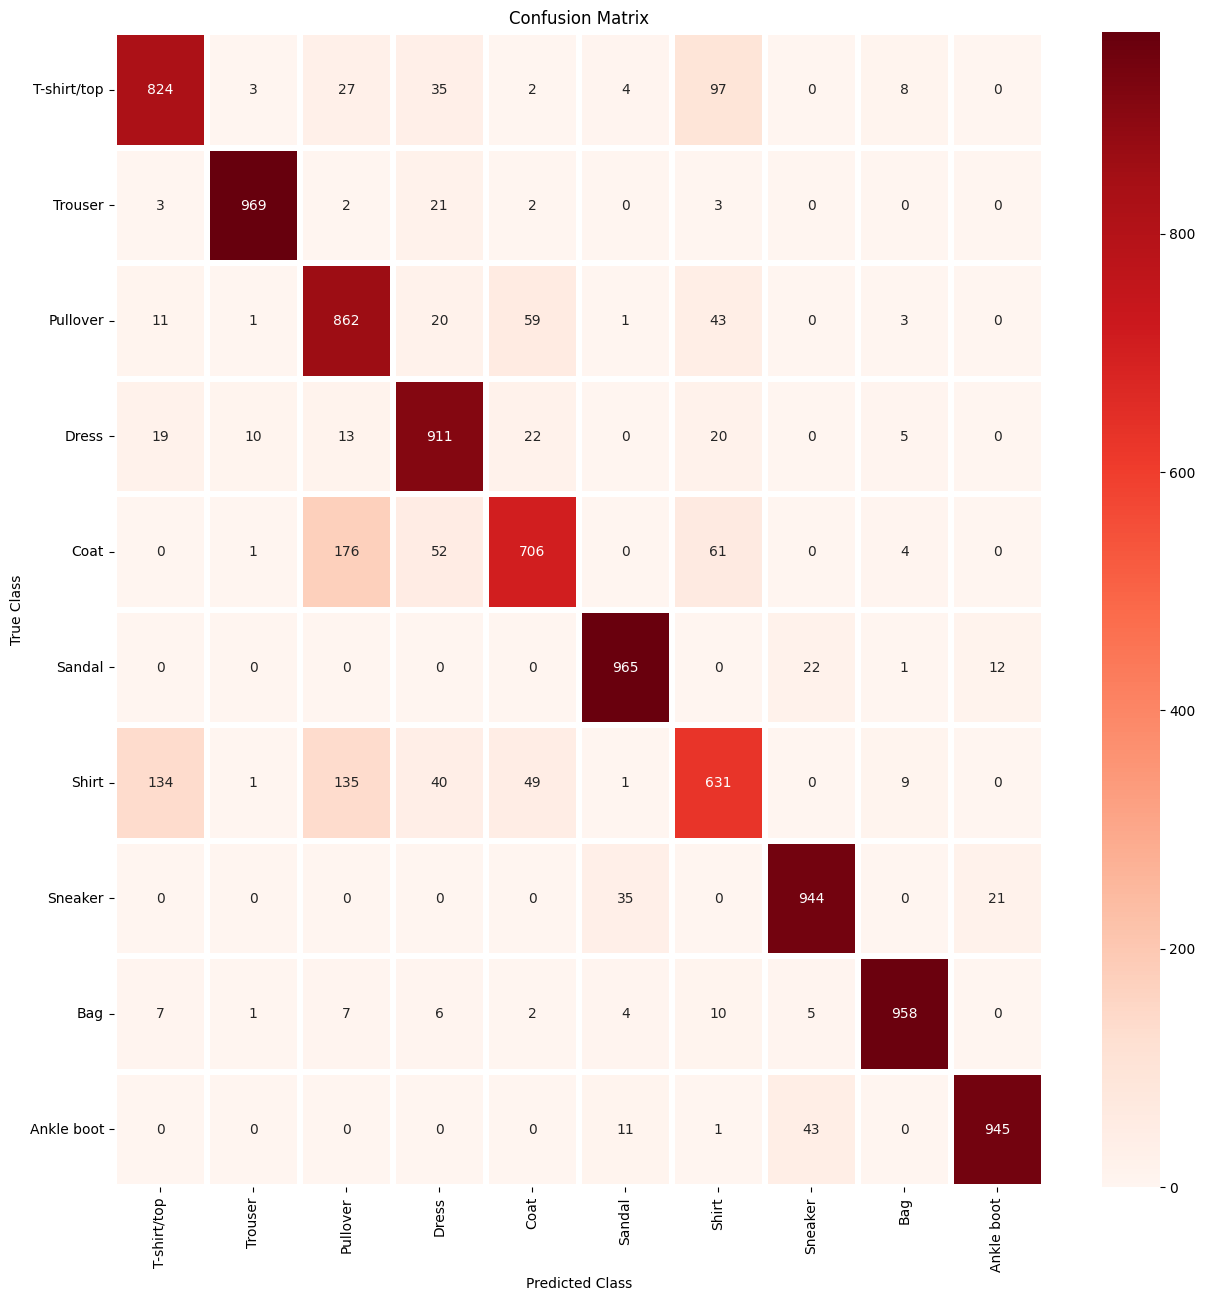

In [50]:
# best config was python train.py -o adam -nhl 3 -sz 128 -a ReLU -lr 0.001 -w_i Xavier -beta 0.9 -beta1 0.9 -beta2 0.999
config_nn = {
        "activation_function": "ReLU",  
        "init": "Xavier",
        "dataset": "fashion_mnist",
        "loss_function": "cross_entropy", 
        "hidden_layers": 5,
        "hidden_layer_sizes": 128
        
}

config_opt = {
    "optimizer": "nadam",
    "eta": 0.0001,  
    "beta": 0.9,
    "beta2": 0.999,
    "beta1": 0.9,
    "weight_decay": 0.0005,
    "epsilon": 1e-8,
    "momentum": 0.9
}

nn = Neural_Network(config_nn, log=0, console=1)
optimizer = Optimizer(nn, config_opt)

t_loss, t_acc, v_loss, v_acc = nn.fit(batch_size=16, epochs=10, optimizer=optimizer)
loss, accuracy = nn.compute_performance(nn.test_img, nn.test_true)  # evaluate on test data
print(f"Test Loss: {loss:.4f}, Test Acc: {accuracy:.2f}%")  # print test loss and accuracy
y_pred = nn.probability(nn.test_img)
generate_and_plot_confusion_matrix(y_pred, nn.test_true) # plot confusion matrox

## Question 8

In [ ]:
sweep_id = wandb.sweep(sweep_config)
wandb.agent(sweep_id,  lambda : train(loss_function = "mean_squared_error"), count = 150)
wandb.finish()

## Question 10 (Update based on Report Answer)

In [46]:
# sweep configuration by tuning only 3 parameters
sweep_config = {
    "method": "random",  
    "project": f"{PROJECT}",
    "metric": {"name": "test_accuracy", "goal": "maximize"},
    "parameters": {
        # "epochs": {"values": [5, 10]},
        # "hidden_layers": {"values": [3, 4, 5]},
        "hidden_layer_sizes": {"values": [32, 64, 128]},
        # "weight_decay": {"values": [0, 0.0005, 0.5]},
        # "learning_rate": {"values": [1e-3, 1e-4]},
        "optimizer": {"values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]},
        # "batch_size": {"values": [16, 32, 64]},
        "activation": {"values": ["sigmoid", "tanh", "ReLU"]},
        # "initialization": {"values": ["Xavier", "random"]},
    }
}


In [47]:
# to call inside wandb.agent()
def train10(loss_function):
    sw = wandb.init(project = PROJECT)
    sw = sw.config

    wandb.run.name = f"opt_{sw.optimizer}_hl_5_bs_64_e_10_act_{sw.activation}_eta_0.005_init_random_hls_{sw.hidden_layer_sizes}_dataset_mnist_{loss_function}"
    # Example: opt_adam_hl_4_bs_32_e_10_act_ReLU_eta_0.001_init_Xavier_hls_64_dataset_mnist_cross_entropy
    config_nn = {
        
        "activation_function": sw.activation, 
        "init" : "random", 
        "dataset" : "mnist",
        "loss_function" : loss_function,
        "hidden_layers": 5,
        "hidden_layer_sizes" : sw.hidden_layer_sizes
    }

    config_opt = {
        "optimizer": sw.optimizer,
        "eta": 0.005,  
        "beta": 0.9,
        "beta2": 0.999,
        "beta1": 0.9,
        "weight_decay": 0.0005,
        "epsilon": 1e-8,
        "momentum": 0.9
    }
    

    nn = Neural_Network(config_nn,log = 1,console=1)
    opt = Optimizer(nn, config_opt)

    t_loss, t_acc, v_loss, v_acc = nn.fit(batch_size=64, epochs=10, optimizer=opt)

    loss, accuracy = nn.compute_performance(nn.test_img, nn.test_true)  # evaluate on test data
    print(f"Test Loss: {loss:.4f}, Test Acc: {accuracy:.2f}%")  # print test loss and accuracy
    wandb.log({"test_accuracy" : accuracy})
    

In [48]:
sweep_id = wandb.sweep(sweep_config)
wandb.agent(sweep_id,  lambda : train10(loss_function = "cross_entropy"), count=54)
wandb.finish()

Create sweep with ID: jtj28a74
Sweep URL: https://wandb.ai/cs24m021-iit-madras/DA6401_DL_Assignment1/sweeps/jtj28a74


wandb: Agent Starting Run: gos6i0n3 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layer_sizes: 64
wandb: 	optimizer: nesterov


Epoch 1: Train Loss=1.4680, Train Acc=50.44%, Val Loss=1.4611, Val Acc=50.13%
Epoch 2: Train Loss=1.0693, Train Acc=64.76%, Val Loss=1.0658, Val Acc=64.70%
Epoch 3: Train Loss=0.8517, Train Acc=72.49%, Val Loss=0.8571, Val Acc=72.38%
Epoch 4: Train Loss=0.7157, Train Acc=77.15%, Val Loss=0.7300, Val Acc=76.63%
Epoch 5: Train Loss=0.6246, Train Acc=80.14%, Val Loss=0.6446, Val Acc=79.17%
Epoch 6: Train Loss=0.5602, Train Acc=82.34%, Val Loss=0.5835, Val Acc=81.43%
Epoch 7: Train Loss=0.5115, Train Acc=84.02%, Val Loss=0.5369, Val Acc=83.45%
Epoch 8: Train Loss=0.4729, Train Acc=85.33%, Val Loss=0.4996, Val Acc=84.68%
Epoch 9: Train Loss=0.4413, Train Acc=86.39%, Val Loss=0.4686, Val Acc=85.77%
Epoch 10: Train Loss=0.4149, Train Acc=87.34%, Val Loss=0.4426, Val Acc=86.57%
Test Loss: 0.4179, Test Acc: 87.11%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,87.11
train_acc,87.34259
train_loss,0.41489
val_acc,86.56667


wandb: Agent Starting Run: 6fw5e6x5 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layer_sizes: 32
wandb: 	optimizer: nadam


Epoch 1: Train Loss=0.2514, Train Acc=93.03%, Val Loss=0.2703, Val Acc=92.28%
Epoch 2: Train Loss=0.1938, Train Acc=94.72%, Val Loss=0.2195, Val Acc=93.73%
Epoch 3: Train Loss=0.1713, Train Acc=95.36%, Val Loss=0.2013, Val Acc=94.30%
Epoch 4: Train Loss=0.1570, Train Acc=95.73%, Val Loss=0.1880, Val Acc=94.57%
Epoch 5: Train Loss=0.1481, Train Acc=95.98%, Val Loss=0.1795, Val Acc=94.77%
Epoch 6: Train Loss=0.1431, Train Acc=96.11%, Val Loss=0.1746, Val Acc=94.67%
Epoch 7: Train Loss=0.1402, Train Acc=96.16%, Val Loss=0.1719, Val Acc=94.85%
Epoch 8: Train Loss=0.1380, Train Acc=96.18%, Val Loss=0.1702, Val Acc=94.93%
Epoch 9: Train Loss=0.1359, Train Acc=96.21%, Val Loss=0.1687, Val Acc=95.05%
Epoch 10: Train Loss=0.1337, Train Acc=96.30%, Val Loss=0.1673, Val Acc=95.12%
Test Loss: 0.1565, Test Acc: 95.36%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▅▆▇▇█████
train_loss,█▅▃▂▂▂▁▁▁▁
val_acc,▁▅▆▇▇▇▇███
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
test_accuracy,95.36
train_acc,96.30185
train_loss,0.13373
val_acc,95.11667


wandb: Agent Starting Run: hh92t88p with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layer_sizes: 64
wandb: 	optimizer: rmsprop


Epoch 1: Train Loss=0.3526, Train Acc=89.72%, Val Loss=0.3602, Val Acc=89.58%
Epoch 2: Train Loss=0.2488, Train Acc=92.92%, Val Loss=0.2645, Val Acc=92.70%
Epoch 3: Train Loss=0.1863, Train Acc=94.93%, Val Loss=0.2054, Val Acc=94.38%
Epoch 4: Train Loss=0.1730, Train Acc=95.35%, Val Loss=0.1939, Val Acc=94.73%
Epoch 5: Train Loss=0.1598, Train Acc=95.66%, Val Loss=0.1821, Val Acc=94.83%
Epoch 6: Train Loss=0.1560, Train Acc=95.65%, Val Loss=0.1804, Val Acc=94.68%
Epoch 7: Train Loss=0.1486, Train Acc=95.84%, Val Loss=0.1750, Val Acc=94.95%
Epoch 8: Train Loss=0.1456, Train Acc=95.96%, Val Loss=0.1728, Val Acc=94.88%
Epoch 9: Train Loss=0.1330, Train Acc=96.38%, Val Loss=0.1597, Val Acc=95.48%
Epoch 10: Train Loss=0.1364, Train Acc=96.22%, Val Loss=0.1647, Val Acc=95.22%
Test Loss: 0.1450, Test Acc: 95.88%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▆▇▇▇▇███
train_loss,█▅▃▂▂▂▁▁▁▁
val_acc,▁▅▇▇▇▇▇▇██
val_loss,█▅▃▂▂▂▂▁▁▁
epoch,10
test_accuracy,95.88
train_acc,96.22222
train_loss,0.13644
val_acc,95.21667


wandb: Agent Starting Run: 2pmz91ob with config:
wandb: 	activation: tanh
wandb: 	hidden_layer_sizes: 32
wandb: 	optimizer: nadam


Epoch 1: Train Loss=1.4845, Train Acc=48.83%, Val Loss=1.4905, Val Acc=48.82%
Epoch 2: Train Loss=1.0763, Train Acc=63.83%, Val Loss=1.1005, Val Acc=62.92%
Epoch 3: Train Loss=0.8041, Train Acc=74.89%, Val Loss=0.8291, Val Acc=74.38%
Epoch 4: Train Loss=0.6360, Train Acc=81.08%, Val Loss=0.6867, Val Acc=79.63%
Epoch 5: Train Loss=0.5111, Train Acc=85.18%, Val Loss=0.5463, Val Acc=84.28%
Epoch 6: Train Loss=0.4320, Train Acc=87.98%, Val Loss=0.4812, Val Acc=87.00%
Epoch 7: Train Loss=0.3625, Train Acc=90.16%, Val Loss=0.4093, Val Acc=88.78%
Epoch 8: Train Loss=0.3237, Train Acc=90.92%, Val Loss=0.3711, Val Acc=90.10%
Epoch 9: Train Loss=0.2825, Train Acc=92.05%, Val Loss=0.3368, Val Acc=90.60%
Epoch 10: Train Loss=0.2592, Train Acc=92.69%, Val Loss=0.3093, Val Acc=91.43%
Test Loss: 0.2906, Test Acc: 92.28%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▇▇████
train_loss,█▆▄▃▂▂▂▁▁▁
val_acc,▁▃▅▆▇▇████
val_loss,█▆▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,92.28
train_acc,92.69074
train_loss,0.25916
val_acc,91.43333


wandb: Agent Starting Run: t4l585yc with config:
wandb: 	activation: tanh
wandb: 	hidden_layer_sizes: 64
wandb: 	optimizer: rmsprop


Epoch 1: Train Loss=1.1744, Train Acc=58.08%, Val Loss=1.1768, Val Acc=58.25%
Epoch 2: Train Loss=0.8053, Train Acc=74.21%, Val Loss=0.8076, Val Acc=74.30%
Epoch 3: Train Loss=0.5419, Train Acc=84.67%, Val Loss=0.5745, Val Acc=84.07%
Epoch 4: Train Loss=0.4315, Train Acc=88.25%, Val Loss=0.4518, Val Acc=87.83%
Epoch 5: Train Loss=0.2988, Train Acc=92.08%, Val Loss=0.3377, Val Acc=91.17%
Epoch 6: Train Loss=0.2892, Train Acc=91.90%, Val Loss=0.3170, Val Acc=91.63%
Epoch 7: Train Loss=0.2685, Train Acc=92.25%, Val Loss=0.2949, Val Acc=91.40%
Epoch 8: Train Loss=0.1715, Train Acc=95.26%, Val Loss=0.2124, Val Acc=94.50%
Epoch 9: Train Loss=0.1639, Train Acc=95.43%, Val Loss=0.1879, Val Acc=94.87%
Epoch 10: Train Loss=0.2779, Train Acc=92.12%, Val Loss=0.3305, Val Acc=91.22%
Test Loss: 0.2957, Test Acc: 91.82%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▆▇▇▇▇██▇
train_loss,█▅▄▃▂▂▂▁▁▂
val_acc,▁▄▆▇▇▇▇██▇
val_loss,█▅▄▃▂▂▂▁▁▂
epoch,10
test_accuracy,91.82
train_acc,92.11852
train_loss,0.27792
val_acc,91.21667


wandb: Agent Starting Run: j2etxz99 with config:
wandb: 	activation: tanh
wandb: 	hidden_layer_sizes: 128
wandb: 	optimizer: nadam


Epoch 1: Train Loss=1.7569, Train Acc=40.53%, Val Loss=1.7963, Val Acc=39.00%
Epoch 2: Train Loss=1.3763, Train Acc=51.69%, Val Loss=1.3915, Val Acc=51.20%
Epoch 3: Train Loss=1.1918, Train Acc=58.07%, Val Loss=1.1917, Val Acc=57.45%
Epoch 4: Train Loss=1.0547, Train Acc=63.49%, Val Loss=1.0742, Val Acc=62.38%
Epoch 5: Train Loss=0.8990, Train Acc=69.81%, Val Loss=0.9282, Val Acc=69.35%
Epoch 6: Train Loss=0.7490, Train Acc=74.40%, Val Loss=0.7791, Val Acc=73.90%
Epoch 7: Train Loss=0.6094, Train Acc=80.10%, Val Loss=0.6659, Val Acc=78.48%
Epoch 8: Train Loss=0.4474, Train Acc=85.98%, Val Loss=0.4949, Val Acc=84.67%
Epoch 9: Train Loss=0.3765, Train Acc=88.22%, Val Loss=0.4154, Val Acc=86.98%
Epoch 10: Train Loss=0.2852, Train Acc=91.31%, Val Loss=0.3346, Val Acc=90.25%
Test Loss: 0.3273, Test Acc: 90.24%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▃▄▅▆▆▇██
train_loss,█▆▅▅▄▃▃▂▁▁
val_acc,▁▃▄▄▅▆▆▇██
val_loss,█▆▅▅▄▃▃▂▁▁
epoch,10
test_accuracy,90.24
train_acc,91.31296
train_loss,0.2852
val_acc,90.25


wandb: Agent Starting Run: b54oxzf3 with config:
wandb: 	activation: ReLU
wandb: 	hidden_layer_sizes: 128
wandb: 	optimizer: nadam


Epoch 1: Train Loss=5.3827, Train Acc=84.39%, Val Loss=5.6979, Val Acc=83.48%
Epoch 2: Train Loss=3.9135, Train Acc=88.64%, Val Loss=4.6684, Val Acc=86.43%
Epoch 3: Train Loss=3.3452, Train Acc=90.28%, Val Loss=4.2860, Val Acc=87.57%
Epoch 4: Train Loss=2.9462, Train Acc=91.42%, Val Loss=3.9885, Val Acc=88.42%
Epoch 5: Train Loss=2.5564, Train Acc=92.57%, Val Loss=3.4494, Val Acc=89.98%
Epoch 6: Train Loss=2.1973, Train Acc=93.59%, Val Loss=3.0084, Val Acc=91.25%
Epoch 7: Train Loss=2.2552, Train Acc=93.42%, Val Loss=3.0362, Val Acc=91.18%
Epoch 8: Train Loss=2.6139, Train Acc=92.37%, Val Loss=3.5155, Val Acc=89.78%
Epoch 9: Train Loss=2.1693, Train Acc=93.66%, Val Loss=3.1060, Val Acc=90.97%
Epoch 10: Train Loss=1.9666, Train Acc=94.25%, Val Loss=2.6504, Val Acc=92.27%
Test Loss: 3.0267, Test Acc: 91.18%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇█▇▇██
train_loss,█▅▄▃▂▁▂▂▁▁
val_acc,▁▃▄▅▆▇▇▆▇█
val_loss,█▆▅▄▃▂▂▃▂▁
epoch,10
test_accuracy,91.18
train_acc,94.24815
train_loss,1.96659
val_acc,92.26667


wandb: Agent Starting Run: vpwg3jm8 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layer_sizes: 64
wandb: 	optimizer: nesterov


Epoch 1: Train Loss=1.4909, Train Acc=51.58%, Val Loss=1.4874, Val Acc=51.13%
Epoch 2: Train Loss=1.0737, Train Acc=66.20%, Val Loss=1.0769, Val Acc=66.45%
Epoch 3: Train Loss=0.8502, Train Acc=73.17%, Val Loss=0.8591, Val Acc=72.62%
Epoch 4: Train Loss=0.7179, Train Acc=77.37%, Val Loss=0.7309, Val Acc=77.17%
Epoch 5: Train Loss=0.6284, Train Acc=80.33%, Val Loss=0.6442, Val Acc=79.78%
Epoch 6: Train Loss=0.5624, Train Acc=82.41%, Val Loss=0.5807, Val Acc=81.90%
Epoch 7: Train Loss=0.5126, Train Acc=84.06%, Val Loss=0.5330, Val Acc=83.43%
Epoch 8: Train Loss=0.4735, Train Acc=85.40%, Val Loss=0.4956, Val Acc=84.75%
Epoch 9: Train Loss=0.4420, Train Acc=86.53%, Val Loss=0.4655, Val Acc=85.65%
Epoch 10: Train Loss=0.4159, Train Acc=87.41%, Val Loss=0.4406, Val Acc=86.67%
Test Loss: 0.4387, Test Acc: 86.54%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,86.54
train_acc,87.40926
train_loss,0.41594
val_acc,86.66667


wandb: Agent Starting Run: qsyt1hdx with config:
wandb: 	activation: ReLU
wandb: 	hidden_layer_sizes: 32
wandb: 	optimizer: nadam


Epoch 1: Train Loss=8.4352, Train Acc=28.83%, Val Loss=8.5828, Val Acc=28.70%
Epoch 2: Train Loss=6.0366, Train Acc=34.43%, Val Loss=5.9782, Val Acc=34.62%
Epoch 3: Train Loss=3.3977, Train Acc=39.90%, Val Loss=3.4460, Val Acc=39.08%
Epoch 4: Train Loss=2.4899, Train Acc=41.54%, Val Loss=2.5633, Val Acc=40.80%
Epoch 5: Train Loss=3.1291, Train Acc=42.20%, Val Loss=3.1669, Val Acc=42.20%
Epoch 6: Train Loss=1.8852, Train Acc=48.63%, Val Loss=2.0177, Val Acc=47.28%
Epoch 7: Train Loss=2.5974, Train Acc=43.32%, Val Loss=2.7240, Val Acc=42.48%
Epoch 8: Train Loss=2.2484, Train Acc=47.86%, Val Loss=2.3512, Val Acc=46.98%
Epoch 9: Train Loss=1.4359, Train Acc=58.58%, Val Loss=1.5013, Val Acc=58.13%
Epoch 10: Train Loss=1.1662, Train Acc=62.93%, Val Loss=1.2038, Val Acc=61.98%
Test Loss: 1.1946, Test Acc: 62.27%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▄▄▅▄▅▇█
train_loss,█▆▃▂▃▂▂▂▁▁
val_acc,▁▂▃▄▄▅▄▅▇█
val_loss,█▆▃▂▃▂▂▂▁▁
epoch,10
test_accuracy,62.27
train_acc,62.93148
train_loss,1.16615
val_acc,61.98333


wandb: Agent Starting Run: 1351mj5c with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layer_sizes: 128
wandb: 	optimizer: rmsprop


Epoch 1: Train Loss=2.3449, Train Acc=9.72%, Val Loss=2.3405, Val Acc=9.87%
Epoch 2: Train Loss=2.3401, Train Acc=9.72%, Val Loss=2.3363, Val Acc=9.87%
Epoch 3: Train Loss=2.3387, Train Acc=9.72%, Val Loss=2.3350, Val Acc=9.87%
Epoch 4: Train Loss=2.3385, Train Acc=9.72%, Val Loss=2.3348, Val Acc=9.87%
Epoch 5: Train Loss=2.3385, Train Acc=9.72%, Val Loss=2.3348, Val Acc=9.87%
Epoch 6: Train Loss=2.3385, Train Acc=9.72%, Val Loss=2.3349, Val Acc=9.87%
Epoch 7: Train Loss=2.3384, Train Acc=9.72%, Val Loss=2.3347, Val Acc=9.87%
Epoch 8: Train Loss=2.3381, Train Acc=9.72%, Val Loss=2.3345, Val Acc=9.87%
Epoch 9: Train Loss=2.3379, Train Acc=9.72%, Val Loss=2.3343, Val Acc=9.87%
Epoch 10: Train Loss=2.3377, Train Acc=9.72%, Val Loss=2.3341, Val Acc=9.87%
Test Loss: 2.3362, Test Acc: 9.82%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▂▂▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▁▁▁
epoch,10
test_accuracy,9.82
train_acc,9.72222
train_loss,2.3377
val_acc,9.86667


wandb: Agent Starting Run: 76cvxwt9 with config:
wandb: 	activation: ReLU
wandb: 	hidden_layer_sizes: 32
wandb: 	optimizer: nesterov


Epoch 1: Train Loss=2.3013, Train Acc=11.25%, Val Loss=2.3022, Val Acc=11.08%
Epoch 2: Train Loss=2.3012, Train Acc=11.25%, Val Loss=2.3023, Val Acc=11.08%
Epoch 3: Train Loss=2.3012, Train Acc=11.25%, Val Loss=2.3023, Val Acc=11.08%
Epoch 4: Train Loss=2.3012, Train Acc=11.25%, Val Loss=2.3023, Val Acc=11.08%
Epoch 5: Train Loss=2.3012, Train Acc=11.25%, Val Loss=2.3023, Val Acc=11.08%
Epoch 6: Train Loss=2.3012, Train Acc=11.25%, Val Loss=2.3023, Val Acc=11.08%
Epoch 7: Train Loss=2.3012, Train Acc=11.25%, Val Loss=2.3023, Val Acc=11.08%
Epoch 8: Train Loss=2.3012, Train Acc=11.25%, Val Loss=2.3023, Val Acc=11.08%
Epoch 9: Train Loss=2.3012, Train Acc=11.25%, Val Loss=2.3023, Val Acc=11.08%
Epoch 10: Train Loss=2.3012, Train Acc=11.25%, Val Loss=2.3023, Val Acc=11.08%
Test Loss: 2.3012, Test Acc: 11.35%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,▁█████████
epoch,10
test_accuracy,11.35
train_acc,11.2537
train_loss,2.30116
val_acc,11.08333


wandb: Agent Starting Run: h77k0fye with config:
wandb: 	activation: ReLU
wandb: 	hidden_layer_sizes: 32
wandb: 	optimizer: nadam


Epoch 1: Train Loss=2.6588, Train Acc=21.03%, Val Loss=2.7054, Val Acc=21.13%
Epoch 2: Train Loss=2.2753, Train Acc=23.11%, Val Loss=2.3381, Val Acc=22.85%
Epoch 3: Train Loss=2.1601, Train Acc=24.04%, Val Loss=2.2117, Val Acc=23.62%
Epoch 4: Train Loss=2.0615, Train Acc=25.26%, Val Loss=2.0978, Val Acc=24.85%
Epoch 5: Train Loss=1.9040, Train Acc=29.68%, Val Loss=1.9290, Val Acc=28.67%
Epoch 6: Train Loss=1.7705, Train Acc=33.51%, Val Loss=1.7756, Val Acc=32.70%
Epoch 7: Train Loss=1.6121, Train Acc=38.26%, Val Loss=1.6167, Val Acc=38.08%
Epoch 8: Train Loss=1.4885, Train Acc=41.27%, Val Loss=1.4981, Val Acc=41.35%
Epoch 9: Train Loss=1.3629, Train Acc=46.64%, Val Loss=1.3582, Val Acc=46.42%
Epoch 10: Train Loss=1.2071, Train Acc=54.06%, Val Loss=1.2092, Val Acc=54.42%
Test Loss: 1.1847, Test Acc: 55.08%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▂▂▃▄▅▅▆█
train_loss,█▆▆▅▄▄▃▂▂▁
val_acc,▁▁▂▂▃▃▅▅▆█
val_loss,█▆▆▅▄▄▃▂▂▁
epoch,10
test_accuracy,55.08
train_acc,54.05556
train_loss,1.20707
val_acc,54.41667


wandb: Agent Starting Run: oh9cu59t with config:
wandb: 	activation: ReLU
wandb: 	hidden_layer_sizes: 64
wandb: 	optimizer: adam


Epoch 1: Train Loss=12.2043, Train Acc=63.54%, Val Loss=12.3512, Val Acc=63.12%
Epoch 2: Train Loss=9.9095, Train Acc=68.91%, Val Loss=10.2770, Val Acc=67.90%
Epoch 3: Train Loss=9.7115, Train Acc=67.51%, Val Loss=9.8031, Val Acc=67.48%
Epoch 4: Train Loss=9.8445, Train Acc=66.11%, Val Loss=9.9869, Val Acc=66.12%
Epoch 5: Train Loss=8.2273, Train Acc=66.68%, Val Loss=8.3109, Val Acc=66.35%
Epoch 6: Train Loss=7.4995, Train Acc=66.61%, Val Loss=7.7562, Val Acc=65.73%
Epoch 7: Train Loss=5.5351, Train Acc=72.52%, Val Loss=5.6830, Val Acc=72.67%
Epoch 8: Train Loss=3.4555, Train Acc=76.36%, Val Loss=3.6243, Val Acc=76.10%
Epoch 9: Train Loss=2.8418, Train Acc=77.19%, Val Loss=3.0456, Val Acc=76.48%
Epoch 10: Train Loss=2.2193, Train Acc=74.65%, Val Loss=2.4636, Val Acc=73.55%
Test Loss: 2.3427, Test Acc: 74.61%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▃▂▃▃▆██▇
train_loss,█▆▆▆▅▅▃▂▁▁
val_acc,▁▄▃▃▃▂▆██▆
val_loss,█▇▆▆▅▅▃▂▁▁
epoch,10
test_accuracy,74.61
train_acc,74.65185
train_loss,2.21934
val_acc,73.55


wandb: Agent Starting Run: j405yf4y with config:
wandb: 	activation: tanh
wandb: 	hidden_layer_sizes: 32
wandb: 	optimizer: sgd


Epoch 1: Train Loss=4.2480, Train Acc=20.30%, Val Loss=4.2620, Val Acc=19.97%
Epoch 2: Train Loss=3.2107, Train Acc=24.94%, Val Loss=3.2254, Val Acc=24.83%
Epoch 3: Train Loss=2.6555, Train Acc=28.36%, Val Loss=2.7228, Val Acc=27.30%
Epoch 4: Train Loss=2.3733, Train Acc=30.77%, Val Loss=2.4090, Val Acc=30.37%
Epoch 5: Train Loss=2.1695, Train Acc=33.05%, Val Loss=2.2175, Val Acc=31.98%
Epoch 6: Train Loss=2.0415, Train Acc=35.63%, Val Loss=2.0917, Val Acc=35.35%
Epoch 7: Train Loss=1.9306, Train Acc=37.56%, Val Loss=1.9765, Val Acc=37.18%
Epoch 8: Train Loss=1.8448, Train Acc=39.64%, Val Loss=1.9092, Val Acc=38.97%
Epoch 9: Train Loss=1.7710, Train Acc=41.48%, Val Loss=1.8402, Val Acc=40.52%
Epoch 10: Train Loss=1.6992, Train Acc=43.29%, Val Loss=1.7711, Val Acc=42.65%
Test Loss: 1.7799, Test Acc: 41.95%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▄▅▆▆▇▇█
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▃▃▄▅▆▆▇▇█
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,41.95
train_acc,43.29444
train_loss,1.69923
val_acc,42.65


wandb: Agent Starting Run: f6peubby with config:
wandb: 	activation: ReLU
wandb: 	hidden_layer_sizes: 64
wandb: 	optimizer: rmsprop


Epoch 1: Train Loss=2.3071, Train Acc=11.25%, Val Loss=2.3299, Val Acc=11.08%
Epoch 2: Train Loss=2.3038, Train Acc=11.25%, Val Loss=2.3280, Val Acc=11.08%
Epoch 3: Train Loss=2.3019, Train Acc=11.25%, Val Loss=2.3242, Val Acc=11.08%
Epoch 4: Train Loss=2.3022, Train Acc=11.26%, Val Loss=2.3235, Val Acc=11.08%
Epoch 5: Train Loss=2.3018, Train Acc=11.26%, Val Loss=2.3233, Val Acc=11.08%
Epoch 6: Train Loss=2.3016, Train Acc=11.26%, Val Loss=2.3183, Val Acc=11.08%
Epoch 7: Train Loss=2.3038, Train Acc=11.26%, Val Loss=2.3130, Val Acc=11.08%
Epoch 8: Train Loss=2.3013, Train Acc=11.26%, Val Loss=2.3127, Val Acc=11.10%
Epoch 9: Train Loss=2.3011, Train Acc=11.26%, Val Loss=2.3023, Val Acc=11.08%
Epoch 10: Train Loss=2.3011, Train Acc=11.26%, Val Loss=2.3023, Val Acc=11.08%
Test Loss: 2.3014, Test Acc: 11.35%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅██▇▇▇██
train_loss,█▄▂▂▂▂▄▁▁▁
val_acc,▁▁▁▁▁▁▁█▁▁
val_loss,██▇▆▆▅▄▄▁▁
epoch,10
test_accuracy,11.35
train_acc,11.25926
train_loss,2.30113
val_acc,11.08333


wandb: Agent Starting Run: vxplvl13 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layer_sizes: 32
wandb: 	optimizer: nesterov


Epoch 1: Train Loss=1.7741, Train Acc=41.54%, Val Loss=1.7860, Val Acc=41.67%
Epoch 2: Train Loss=1.3038, Train Acc=57.68%, Val Loss=1.3095, Val Acc=56.95%
Epoch 3: Train Loss=1.0491, Train Acc=66.54%, Val Loss=1.0547, Val Acc=65.80%
Epoch 4: Train Loss=0.8899, Train Acc=72.20%, Val Loss=0.8950, Val Acc=71.55%
Epoch 5: Train Loss=0.7819, Train Acc=75.82%, Val Loss=0.7872, Val Acc=75.87%
Epoch 6: Train Loss=0.7025, Train Acc=78.39%, Val Loss=0.7079, Val Acc=78.57%
Epoch 7: Train Loss=0.6417, Train Acc=80.41%, Val Loss=0.6473, Val Acc=80.38%
Epoch 8: Train Loss=0.5931, Train Acc=82.09%, Val Loss=0.5995, Val Acc=81.92%
Epoch 9: Train Loss=0.5531, Train Acc=83.34%, Val Loss=0.5608, Val Acc=83.15%
Epoch 10: Train Loss=0.5197, Train Acc=84.53%, Val Loss=0.5288, Val Acc=84.13%
Test Loss: 0.5126, Test Acc: 84.54%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,84.54
train_acc,84.52778
train_loss,0.51973
val_acc,84.13333


wandb: Agent Starting Run: lvk7cu75 with config:
wandb: 	activation: tanh
wandb: 	hidden_layer_sizes: 64
wandb: 	optimizer: rmsprop


Epoch 1: Train Loss=1.2078, Train Acc=53.40%, Val Loss=1.2058, Val Acc=54.35%
Epoch 2: Train Loss=0.8262, Train Acc=72.77%, Val Loss=0.8313, Val Acc=72.82%
Epoch 3: Train Loss=0.5954, Train Acc=82.97%, Val Loss=0.6041, Val Acc=83.07%
Epoch 4: Train Loss=0.4125, Train Acc=88.62%, Val Loss=0.4395, Val Acc=88.05%
Epoch 5: Train Loss=0.3940, Train Acc=89.40%, Val Loss=0.4145, Val Acc=89.12%
Epoch 6: Train Loss=0.2885, Train Acc=92.04%, Val Loss=0.3166, Val Acc=91.47%
Epoch 7: Train Loss=0.2581, Train Acc=92.76%, Val Loss=0.2881, Val Acc=91.75%
Epoch 8: Train Loss=0.2677, Train Acc=92.17%, Val Loss=0.2840, Val Acc=91.57%
Epoch 9: Train Loss=0.1854, Train Acc=94.89%, Val Loss=0.2178, Val Acc=94.13%
Epoch 10: Train Loss=0.1738, Train Acc=95.31%, Val Loss=0.2096, Val Acc=94.47%
Test Loss: 0.2067, Test Acc: 94.49%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▆▇▇▇█▇██
train_loss,█▅▄▃▂▂▂▂▁▁
val_acc,▁▄▆▇▇▇█▇██
val_loss,█▅▄▃▂▂▂▂▁▁
epoch,10
test_accuracy,94.49
train_acc,95.31111
train_loss,0.17383
val_acc,94.46667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dod7q4vo with config:
wandb: 	activation: tanh
wandb: 	hidden_layer_sizes: 128
wandb: 	optimizer: sgd


Epoch 1: Train Loss=9.4251, Train Acc=21.60%, Val Loss=9.4228, Val Acc=21.93%
Epoch 2: Train Loss=6.8433, Train Acc=26.86%, Val Loss=6.8559, Val Acc=27.35%
Epoch 3: Train Loss=5.2731, Train Acc=30.18%, Val Loss=5.2607, Val Acc=30.10%
Epoch 4: Train Loss=3.9966, Train Acc=33.00%, Val Loss=4.0429, Val Acc=32.95%
Epoch 5: Train Loss=2.9916, Train Acc=33.90%, Val Loss=3.0874, Val Acc=33.00%
Epoch 6: Train Loss=2.3307, Train Acc=36.41%, Val Loss=2.4095, Val Acc=34.98%
Epoch 7: Train Loss=1.9770, Train Acc=39.09%, Val Loss=2.0464, Val Acc=37.72%
Epoch 8: Train Loss=1.7906, Train Acc=41.54%, Val Loss=1.8508, Val Acc=40.08%
Epoch 9: Train Loss=1.6724, Train Acc=43.54%, Val Loss=1.7553, Val Acc=41.73%
Epoch 10: Train Loss=1.5787, Train Acc=45.86%, Val Loss=1.6726, Val Acc=43.95%
Test Loss: 1.6328, Test Acc: 44.88%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▃▄▅▅▆▇▇█
train_loss,█▆▄▃▂▂▁▁▁▁
val_acc,▁▃▄▅▅▅▆▇▇█
val_loss,█▆▄▃▂▂▁▁▁▁
epoch,10
test_accuracy,44.88
train_acc,45.85741
train_loss,1.57871
val_acc,43.95


wandb: Agent Starting Run: ov7xcxo4 with config:
wandb: 	activation: ReLU
wandb: 	hidden_layer_sizes: 128
wandb: 	optimizer: sgd


/tmp/ipykernel_17767/4278465179.py:65: RuntimeWarning: overflow encountered in matmul
  final_linear_output = self.h[num_layers-1] @ self.weights[num_layers]
/tmp/ipykernel_17767/1830457294.py:12: RuntimeWarning: invalid value encountered in subtract
  exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # numerical stability


Epoch 1: Train Loss=nan, Train Acc=9.88%, Val Loss=nan, Val Acc=9.82%
Epoch 2: Train Loss=nan, Train Acc=9.88%, Val Loss=nan, Val Acc=9.82%
Epoch 3: Train Loss=nan, Train Acc=9.88%, Val Loss=nan, Val Acc=9.82%
Epoch 4: Train Loss=nan, Train Acc=9.88%, Val Loss=nan, Val Acc=9.82%
Epoch 5: Train Loss=nan, Train Acc=9.88%, Val Loss=nan, Val Acc=9.82%
Epoch 6: Train Loss=nan, Train Acc=9.88%, Val Loss=nan, Val Acc=9.82%
Epoch 7: Train Loss=nan, Train Acc=9.88%, Val Loss=nan, Val Acc=9.82%
Epoch 8: Train Loss=nan, Train Acc=9.88%, Val Loss=nan, Val Acc=9.82%
Epoch 9: Train Loss=nan, Train Acc=9.88%, Val Loss=nan, Val Acc=9.82%
Epoch 10: Train Loss=nan, Train Acc=9.88%, Val Loss=nan, Val Acc=9.82%
Test Loss: nan, Test Acc: 9.80%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,9.8
train_acc,9.87778
train_loss,nan
val_acc,9.81667
val_loss,nan


wandb: Agent Starting Run: tpkp1vqr with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layer_sizes: 128
wandb: 	optimizer: nesterov


Epoch 1: Train Loss=1.0858, Train Acc=64.05%, Val Loss=1.1017, Val Acc=63.27%
Epoch 2: Train Loss=0.8122, Train Acc=73.70%, Val Loss=0.8430, Val Acc=72.30%
Epoch 3: Train Loss=0.6731, Train Acc=78.61%, Val Loss=0.7145, Val Acc=77.23%
Epoch 4: Train Loss=0.5830, Train Acc=81.77%, Val Loss=0.6279, Val Acc=80.35%
Epoch 5: Train Loss=0.5187, Train Acc=83.89%, Val Loss=0.5660, Val Acc=82.77%
Epoch 6: Train Loss=0.4695, Train Acc=85.46%, Val Loss=0.5192, Val Acc=84.07%
Epoch 7: Train Loss=0.4301, Train Acc=86.69%, Val Loss=0.4816, Val Acc=85.35%
Epoch 8: Train Loss=0.3978, Train Acc=87.74%, Val Loss=0.4502, Val Acc=86.20%
Epoch 9: Train Loss=0.3709, Train Acc=88.62%, Val Loss=0.4236, Val Acc=87.17%
Epoch 10: Train Loss=0.3481, Train Acc=89.32%, Val Loss=0.4009, Val Acc=87.92%
Test Loss: 0.3670, Test Acc: 88.74%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,88.74
train_acc,89.32037
train_loss,0.34809
val_acc,87.91667


wandb: Agent Starting Run: est0frmf with config:
wandb: 	activation: tanh
wandb: 	hidden_layer_sizes: 32
wandb: 	optimizer: momentum


Epoch 1: Train Loss=1.6721, Train Acc=44.57%, Val Loss=1.6930, Val Acc=44.13%
Epoch 2: Train Loss=1.3095, Train Acc=56.13%, Val Loss=1.3490, Val Acc=55.75%
Epoch 3: Train Loss=1.1121, Train Acc=63.18%, Val Loss=1.1604, Val Acc=62.07%
Epoch 4: Train Loss=1.0048, Train Acc=67.04%, Val Loss=1.0410, Val Acc=65.92%
Epoch 5: Train Loss=0.9136, Train Acc=70.09%, Val Loss=0.9527, Val Acc=69.00%
Epoch 6: Train Loss=0.8478, Train Acc=72.68%, Val Loss=0.8976, Val Acc=71.07%
Epoch 7: Train Loss=0.7959, Train Acc=74.56%, Val Loss=0.8392, Val Acc=73.05%
Epoch 8: Train Loss=0.7480, Train Acc=76.40%, Val Loss=0.7977, Val Acc=74.95%
Epoch 9: Train Loss=0.7040, Train Acc=77.84%, Val Loss=0.7486, Val Acc=76.87%
Epoch 10: Train Loss=0.6657, Train Acc=79.21%, Val Loss=0.7140, Val Acc=78.32%
Test Loss: 0.6840, Test Acc: 79.17%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▃▅▅▆▇▇▇██
val_loss,█▆▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,79.17
train_acc,79.20741
train_loss,0.66571
val_acc,78.31667


wandb: Agent Starting Run: 8pw4k21z with config:
wandb: 	activation: ReLU
wandb: 	hidden_layer_sizes: 64
wandb: 	optimizer: adam


Epoch 1: Train Loss=14.2633, Train Acc=57.03%, Val Loss=14.5821, Val Acc=55.92%
Epoch 2: Train Loss=13.3435, Train Acc=51.12%, Val Loss=13.5833, Val Acc=50.27%
Epoch 3: Train Loss=11.1662, Train Acc=46.06%, Val Loss=11.0654, Val Acc=45.77%
Epoch 4: Train Loss=6.3090, Train Acc=44.60%, Val Loss=6.7015, Val Acc=43.93%
Epoch 5: Train Loss=5.3841, Train Acc=42.97%, Val Loss=5.5942, Val Acc=42.80%
Epoch 6: Train Loss=3.9353, Train Acc=51.33%, Val Loss=4.0489, Val Acc=51.87%
Epoch 7: Train Loss=2.4506, Train Acc=53.17%, Val Loss=2.5635, Val Acc=52.68%
Epoch 8: Train Loss=4.4052, Train Acc=47.39%, Val Loss=4.3621, Val Acc=48.00%
Epoch 9: Train Loss=1.9160, Train Acc=54.36%, Val Loss=2.0054, Val Acc=54.30%
Epoch 10: Train Loss=1.8885, Train Acc=56.48%, Val Loss=1.9317, Val Acc=57.07%
Test Loss: 1.8646, Test Acc: 58.14%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,█▅▃▂▁▅▆▃▇█
train_loss,█▇▆▄▃▂▁▂▁▁
val_acc,▇▅▂▂▁▅▆▄▇█
val_loss,█▇▆▄▃▂▁▂▁▁
epoch,10
test_accuracy,58.14
train_acc,56.47963
train_loss,1.88852
val_acc,57.06667


wandb: Agent Starting Run: qs175noi with config:
wandb: 	activation: ReLU
wandb: 	hidden_layer_sizes: 64
wandb: 	optimizer: rmsprop


Epoch 1: Train Loss=13.6762, Train Acc=47.79%, Val Loss=13.9412, Val Acc=46.78%
Epoch 2: Train Loss=6.8002, Train Acc=54.09%, Val Loss=6.9137, Val Acc=53.68%
Epoch 3: Train Loss=3.9075, Train Acc=59.46%, Val Loss=3.9029, Val Acc=59.67%
Epoch 4: Train Loss=2.5201, Train Acc=60.86%, Val Loss=2.6138, Val Acc=60.63%
Epoch 5: Train Loss=2.8656, Train Acc=57.84%, Val Loss=2.9969, Val Acc=56.78%
Epoch 6: Train Loss=1.6729, Train Acc=62.73%, Val Loss=1.8144, Val Acc=62.68%
Epoch 7: Train Loss=1.3711, Train Acc=67.53%, Val Loss=1.5009, Val Acc=67.35%
Epoch 8: Train Loss=1.5771, Train Acc=58.39%, Val Loss=1.6232, Val Acc=58.07%
Epoch 9: Train Loss=0.9590, Train Acc=71.57%, Val Loss=1.0032, Val Acc=71.50%
Epoch 10: Train Loss=1.0255, Train Acc=67.89%, Val Loss=1.0500, Val Acc=67.95%
Test Loss: 1.0340, Test Acc: 67.31%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▄▅▇▄█▇
train_loss,█▄▃▂▂▁▁▁▁▁
val_acc,▁▃▅▅▄▆▇▄█▇
val_loss,█▄▃▂▂▁▁▁▁▁
epoch,10
test_accuracy,67.31
train_acc,67.88704
train_loss,1.02549
val_acc,67.95


wandb: Agent Starting Run: a1cg5g6z with config:
wandb: 	activation: tanh
wandb: 	hidden_layer_sizes: 64
wandb: 	optimizer: momentum


Epoch 1: Train Loss=1.7338, Train Acc=39.98%, Val Loss=1.7491, Val Acc=39.23%
Epoch 2: Train Loss=1.4514, Train Acc=49.33%, Val Loss=1.4972, Val Acc=47.85%
Epoch 3: Train Loss=1.2736, Train Acc=55.21%, Val Loss=1.3156, Val Acc=54.00%
Epoch 4: Train Loss=1.1715, Train Acc=59.18%, Val Loss=1.2056, Val Acc=57.90%
Epoch 5: Train Loss=1.0883, Train Acc=62.67%, Val Loss=1.1085, Val Acc=61.67%
Epoch 6: Train Loss=0.9876, Train Acc=66.05%, Val Loss=1.0267, Val Acc=64.90%
Epoch 7: Train Loss=0.9022, Train Acc=70.85%, Val Loss=0.9294, Val Acc=70.65%
Epoch 8: Train Loss=0.8213, Train Acc=74.59%, Val Loss=0.8642, Val Acc=73.80%
Epoch 9: Train Loss=0.7603, Train Acc=77.33%, Val Loss=0.8052, Val Acc=76.27%
Epoch 10: Train Loss=0.7155, Train Acc=78.74%, Val Loss=0.7617, Val Acc=77.35%
Test Loss: 0.7508, Test Acc: 77.85%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▄▅▆▇▇██
train_loss,█▆▅▄▄▃▂▂▁▁
val_acc,▁▃▄▄▅▆▇▇██
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
test_accuracy,77.85
train_acc,78.73704
train_loss,0.71549
val_acc,77.35


wandb: Agent Starting Run: 7qhqwmvq with config:
wandb: 	activation: ReLU
wandb: 	hidden_layer_sizes: 64
wandb: 	optimizer: momentum


Epoch 1: Train Loss=2.3012, Train Acc=11.25%, Val Loss=2.3024, Val Acc=11.08%
Epoch 2: Train Loss=2.3012, Train Acc=11.25%, Val Loss=2.3023, Val Acc=11.08%
Epoch 3: Train Loss=2.3012, Train Acc=11.25%, Val Loss=2.3023, Val Acc=11.08%
Epoch 4: Train Loss=2.3012, Train Acc=11.25%, Val Loss=2.3023, Val Acc=11.08%
Epoch 5: Train Loss=2.3012, Train Acc=11.25%, Val Loss=2.3023, Val Acc=11.08%
Epoch 6: Train Loss=2.3012, Train Acc=11.25%, Val Loss=2.3023, Val Acc=11.08%
Epoch 7: Train Loss=2.3012, Train Acc=11.25%, Val Loss=2.3023, Val Acc=11.08%
Epoch 8: Train Loss=2.3012, Train Acc=11.25%, Val Loss=2.3023, Val Acc=11.08%
Epoch 9: Train Loss=2.3012, Train Acc=11.25%, Val Loss=2.3023, Val Acc=11.08%
Epoch 10: Train Loss=2.3012, Train Acc=11.25%, Val Loss=2.3023, Val Acc=11.08%
Test Loss: 2.3012, Test Acc: 11.35%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,11.35
train_acc,11.2537
train_loss,2.30116
val_acc,11.08333


wandb: Agent Starting Run: tfmzkqkp with config:
wandb: 	activation: tanh
wandb: 	hidden_layer_sizes: 128
wandb: 	optimizer: sgd


Epoch 1: Train Loss=9.7312, Train Acc=22.38%, Val Loss=9.9274, Val Acc=22.05%
Epoch 2: Train Loss=6.9254, Train Acc=30.19%, Val Loss=7.0426, Val Acc=30.23%
Epoch 3: Train Loss=5.6659, Train Acc=32.66%, Val Loss=5.6901, Val Acc=32.60%
Epoch 4: Train Loss=4.4125, Train Acc=34.93%, Val Loss=4.4882, Val Acc=34.37%
Epoch 5: Train Loss=3.4772, Train Acc=37.87%, Val Loss=3.5494, Val Acc=37.53%
Epoch 6: Train Loss=2.7093, Train Acc=38.59%, Val Loss=2.7904, Val Acc=37.75%
Epoch 7: Train Loss=2.1407, Train Acc=39.80%, Val Loss=2.1892, Val Acc=39.75%
Epoch 8: Train Loss=1.8706, Train Acc=42.01%, Val Loss=1.9635, Val Acc=41.52%
Epoch 9: Train Loss=1.7197, Train Acc=44.73%, Val Loss=1.7803, Val Acc=42.87%
Epoch 10: Train Loss=1.6207, Train Acc=46.30%, Val Loss=1.7016, Val Acc=44.67%
Test Loss: 1.6641, Test Acc: 45.43%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▆▇██
train_loss,█▆▄▃▃▂▁▁▁▁
val_acc,▁▄▄▅▆▆▆▇▇█
val_loss,█▆▄▃▃▂▁▁▁▁
epoch,10
test_accuracy,45.43
train_acc,46.2963
train_loss,1.6207
val_acc,44.66667


wandb: Agent Starting Run: as7wc3dk with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layer_sizes: 128
wandb: 	optimizer: momentum


Epoch 1: Train Loss=1.1611, Train Acc=61.35%, Val Loss=1.1914, Val Acc=59.92%
Epoch 2: Train Loss=0.8583, Train Acc=71.90%, Val Loss=0.8881, Val Acc=71.05%
Epoch 3: Train Loss=0.7029, Train Acc=77.37%, Val Loss=0.7355, Val Acc=76.25%
Epoch 4: Train Loss=0.6053, Train Acc=80.83%, Val Loss=0.6406, Val Acc=79.75%
Epoch 5: Train Loss=0.5356, Train Acc=83.30%, Val Loss=0.5732, Val Acc=82.02%
Epoch 6: Train Loss=0.4832, Train Acc=85.10%, Val Loss=0.5234, Val Acc=83.87%
Epoch 7: Train Loss=0.4419, Train Acc=86.47%, Val Loss=0.4849, Val Acc=85.08%
Epoch 8: Train Loss=0.4081, Train Acc=87.53%, Val Loss=0.4538, Val Acc=85.97%
Epoch 9: Train Loss=0.3796, Train Acc=88.51%, Val Loss=0.4274, Val Acc=87.03%
Epoch 10: Train Loss=0.3550, Train Acc=89.25%, Val Loss=0.4044, Val Acc=87.40%
Test Loss: 0.3908, Test Acc: 88.14%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,88.14
train_acc,89.24815
train_loss,0.35499
val_acc,87.4


wandb: Agent Starting Run: uj44hpop with config:
wandb: 	activation: tanh
wandb: 	hidden_layer_sizes: 32
wandb: 	optimizer: nadam


Epoch 1: Train Loss=1.6575, Train Acc=41.59%, Val Loss=1.7072, Val Acc=40.35%
Epoch 2: Train Loss=1.2113, Train Acc=57.87%, Val Loss=1.2555, Val Acc=56.28%
Epoch 3: Train Loss=0.9548, Train Acc=67.79%, Val Loss=1.0030, Val Acc=66.62%
Epoch 4: Train Loss=0.7652, Train Acc=76.37%, Val Loss=0.8038, Val Acc=76.12%
Epoch 5: Train Loss=0.6330, Train Acc=80.73%, Val Loss=0.6662, Val Acc=79.97%
Epoch 6: Train Loss=0.5004, Train Acc=85.65%, Val Loss=0.5483, Val Acc=84.77%
Epoch 7: Train Loss=0.4174, Train Acc=88.38%, Val Loss=0.4612, Val Acc=87.22%
Epoch 8: Train Loss=0.3507, Train Acc=90.19%, Val Loss=0.3942, Val Acc=89.10%
Epoch 9: Train Loss=0.3043, Train Acc=91.46%, Val Loss=0.3375, Val Acc=91.03%
Epoch 10: Train Loss=0.2586, Train Acc=92.73%, Val Loss=0.3107, Val Acc=91.65%
Test Loss: 0.2995, Test Acc: 91.76%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇███
train_loss,█▆▄▄▃▂▂▁▁▁
val_acc,▁▃▅▆▆▇▇███
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,91.76
train_acc,92.72593
train_loss,0.25859
val_acc,91.65


wandb: Agent Starting Run: zpejmv6o with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layer_sizes: 128
wandb: 	optimizer: nesterov


Epoch 1: Train Loss=1.1778, Train Acc=59.88%, Val Loss=1.1835, Val Acc=59.63%
Epoch 2: Train Loss=0.8644, Train Acc=71.27%, Val Loss=0.8760, Val Acc=70.30%
Epoch 3: Train Loss=0.7081, Train Acc=76.95%, Val Loss=0.7305, Val Acc=76.10%
Epoch 4: Train Loss=0.6098, Train Acc=80.41%, Val Loss=0.6392, Val Acc=79.20%
Epoch 5: Train Loss=0.5402, Train Acc=82.96%, Val Loss=0.5738, Val Acc=81.83%
Epoch 6: Train Loss=0.4874, Train Acc=84.72%, Val Loss=0.5233, Val Acc=83.48%
Epoch 7: Train Loss=0.4457, Train Acc=86.09%, Val Loss=0.4831, Val Acc=84.92%
Epoch 8: Train Loss=0.4116, Train Acc=87.19%, Val Loss=0.4508, Val Acc=86.08%
Epoch 9: Train Loss=0.3829, Train Acc=88.19%, Val Loss=0.4244, Val Acc=86.88%
Epoch 10: Train Loss=0.3584, Train Acc=88.97%, Val Loss=0.4021, Val Acc=87.53%
Test Loss: 0.3898, Test Acc: 88.19%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,88.19
train_acc,88.97037
train_loss,0.35835
val_acc,87.53333


wandb: Agent Starting Run: sgvzp1d0 with config:
wandb: 	activation: ReLU
wandb: 	hidden_layer_sizes: 64
wandb: 	optimizer: adam


Epoch 1: Train Loss=8.6398, Train Acc=74.29%, Val Loss=9.5005, Val Acc=71.63%
Epoch 2: Train Loss=7.3846, Train Acc=77.33%, Val Loss=8.1370, Val Acc=75.18%
Epoch 3: Train Loss=6.7233, Train Acc=78.89%, Val Loss=7.5262, Val Acc=76.55%
Epoch 4: Train Loss=5.9572, Train Acc=80.63%, Val Loss=6.7532, Val Acc=78.42%
Epoch 5: Train Loss=5.6601, Train Acc=81.32%, Val Loss=6.4567, Val Acc=78.93%
Epoch 6: Train Loss=5.1644, Train Acc=81.93%, Val Loss=5.9621, Val Acc=79.77%
Epoch 7: Train Loss=4.6641, Train Acc=83.21%, Val Loss=5.4727, Val Acc=80.67%
Epoch 8: Train Loss=3.9287, Train Acc=84.33%, Val Loss=4.6526, Val Acc=82.22%
Epoch 9: Train Loss=4.6110, Train Acc=80.45%, Val Loss=5.4003, Val Acc=78.25%
Epoch 10: Train Loss=2.9955, Train Acc=85.07%, Val Loss=3.6481, Val Acc=82.82%
Test Loss: 3.1969, Test Acc: 84.72%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇█▅█
train_loss,█▆▆▅▄▄▃▂▃▁
val_acc,▁▃▄▅▆▆▇█▅█
val_loss,█▆▆▅▄▄▃▂▃▁
epoch,10
test_accuracy,84.72
train_acc,85.06852
train_loss,2.99551
val_acc,82.81667


wandb: Agent Starting Run: 5xw0xf4h with config:
wandb: 	activation: tanh
wandb: 	hidden_layer_sizes: 128
wandb: 	optimizer: sgd


Epoch 1: Train Loss=8.4772, Train Acc=22.70%, Val Loss=8.2716, Val Acc=23.87%
Epoch 2: Train Loss=6.8068, Train Acc=28.10%, Val Loss=6.7488, Val Acc=27.75%
Epoch 3: Train Loss=5.4946, Train Acc=32.65%, Val Loss=5.6120, Val Acc=30.85%
Epoch 4: Train Loss=4.4613, Train Acc=34.77%, Val Loss=4.5339, Val Acc=34.82%
Epoch 5: Train Loss=3.6388, Train Acc=37.72%, Val Loss=3.6647, Val Acc=38.48%
Epoch 6: Train Loss=2.9454, Train Acc=38.86%, Val Loss=3.0036, Val Acc=39.48%
Epoch 7: Train Loss=2.3976, Train Acc=42.48%, Val Loss=2.4564, Val Acc=41.42%
Epoch 8: Train Loss=2.0885, Train Acc=44.39%, Val Loss=2.0682, Val Acc=45.03%
Epoch 9: Train Loss=1.8793, Train Acc=45.43%, Val Loss=1.9001, Val Acc=45.35%
Epoch 10: Train Loss=1.7096, Train Acc=48.86%, Val Loss=1.7616, Val Acc=49.17%
Test Loss: 1.7330, Test Acc: 48.41%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▄▄▅▅▆▇▇█
train_loss,█▆▅▄▃▂▂▁▁▁
val_acc,▁▂▃▄▅▅▆▇▇█
val_loss,█▆▅▄▃▂▂▁▁▁
epoch,10
test_accuracy,48.41
train_acc,48.85741
train_loss,1.70961
val_acc,49.16667


wandb: Agent Starting Run: sn6fxiue with config:
wandb: 	activation: ReLU
wandb: 	hidden_layer_sizes: 64
wandb: 	optimizer: rmsprop


Epoch 1: Train Loss=2.3286, Train Acc=14.96%, Val Loss=2.3670, Val Acc=15.18%
Epoch 2: Train Loss=2.2370, Train Acc=14.59%, Val Loss=2.2951, Val Acc=14.75%
Epoch 3: Train Loss=2.2084, Train Acc=15.02%, Val Loss=2.2473, Val Acc=15.10%
Epoch 4: Train Loss=2.1779, Train Acc=17.06%, Val Loss=2.2030, Val Acc=17.22%
Epoch 5: Train Loss=2.1295, Train Acc=19.69%, Val Loss=2.1464, Val Acc=19.45%
Epoch 6: Train Loss=2.0462, Train Acc=22.06%, Val Loss=2.0567, Val Acc=21.70%
Epoch 7: Train Loss=1.9547, Train Acc=24.55%, Val Loss=1.9896, Val Acc=24.52%
Epoch 8: Train Loss=2.0080, Train Acc=22.03%, Val Loss=2.0118, Val Acc=22.22%
Epoch 9: Train Loss=1.9477, Train Acc=23.91%, Val Loss=1.9856, Val Acc=23.90%
Epoch 10: Train Loss=1.8839, Train Acc=25.93%, Val Loss=1.9035, Val Acc=26.13%
Test Loss: 1.8854, Test Acc: 25.67%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁▃▄▆▇▆▇█
train_loss,█▇▆▆▅▄▂▃▂▁
val_acc,▁▁▁▃▄▅▇▆▇█
val_loss,█▇▆▆▅▃▂▃▂▁
epoch,10
test_accuracy,25.67
train_acc,25.93148
train_loss,1.88392
val_acc,26.13333


wandb: Agent Starting Run: 8ka20kt8 with config:
wandb: 	activation: ReLU
wandb: 	hidden_layer_sizes: 64
wandb: 	optimizer: adam


Epoch 1: Train Loss=9.1010, Train Acc=73.11%, Val Loss=9.5776, Val Acc=71.68%
Epoch 2: Train Loss=8.1298, Train Acc=75.25%, Val Loss=8.5413, Val Acc=73.90%
Epoch 3: Train Loss=6.8750, Train Acc=78.42%, Val Loss=7.2208, Val Acc=77.58%
Epoch 4: Train Loss=6.0468, Train Acc=79.87%, Val Loss=6.6849, Val Acc=77.90%
Epoch 5: Train Loss=5.3651, Train Acc=80.93%, Val Loss=5.9630, Val Acc=79.13%
Epoch 6: Train Loss=4.5468, Train Acc=82.21%, Val Loss=5.1635, Val Acc=80.23%
Epoch 7: Train Loss=3.9058, Train Acc=82.13%, Val Loss=4.5540, Val Acc=79.88%
Epoch 8: Train Loss=3.4744, Train Acc=81.89%, Val Loss=4.0139, Val Acc=80.18%
Epoch 9: Train Loss=2.6352, Train Acc=82.45%, Val Loss=3.1453, Val Acc=80.83%
Epoch 10: Train Loss=1.9961, Train Acc=82.44%, Val Loss=2.4254, Val Acc=80.60%
Test Loss: 2.2005, Test Acc: 82.22%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▇█████
train_loss,█▇▆▅▄▄▃▂▂▁
val_acc,▁▃▆▆▇█▇███
val_loss,█▇▆▅▄▄▃▃▂▁
epoch,10
test_accuracy,82.22
train_acc,82.43519
train_loss,1.99608
val_acc,80.6


wandb: Agent Starting Run: j0vdj26t with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layer_sizes: 128
wandb: 	optimizer: nesterov


Epoch 1: Train Loss=1.1504, Train Acc=61.24%, Val Loss=1.1502, Val Acc=60.03%
Epoch 2: Train Loss=0.8328, Train Acc=72.83%, Val Loss=0.8488, Val Acc=71.75%
Epoch 3: Train Loss=0.6862, Train Acc=78.03%, Val Loss=0.7108, Val Acc=76.90%
Epoch 4: Train Loss=0.5938, Train Acc=81.34%, Val Loss=0.6232, Val Acc=79.95%
Epoch 5: Train Loss=0.5279, Train Acc=83.62%, Val Loss=0.5605, Val Acc=82.02%
Epoch 6: Train Loss=0.4780, Train Acc=85.27%, Val Loss=0.5132, Val Acc=83.63%
Epoch 7: Train Loss=0.4387, Train Acc=86.44%, Val Loss=0.4760, Val Acc=85.02%
Epoch 8: Train Loss=0.4067, Train Acc=87.46%, Val Loss=0.4456, Val Acc=86.00%
Epoch 9: Train Loss=0.3799, Train Acc=88.35%, Val Loss=0.4201, Val Acc=86.90%
Epoch 10: Train Loss=0.3571, Train Acc=89.09%, Val Loss=0.3984, Val Acc=87.75%
Test Loss: 0.3857, Test Acc: 88.13%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,88.13
train_acc,89.09259
train_loss,0.35706
val_acc,87.75


wandb: Agent Starting Run: rxr2ufga with config:
wandb: 	activation: ReLU
wandb: 	hidden_layer_sizes: 32
wandb: 	optimizer: rmsprop


Epoch 1: Train Loss=2.3010, Train Acc=11.38%, Val Loss=2.2967, Val Acc=11.10%
Epoch 2: Train Loss=2.2752, Train Acc=11.66%, Val Loss=2.2788, Val Acc=12.00%
Epoch 3: Train Loss=2.2638, Train Acc=12.08%, Val Loss=2.2743, Val Acc=11.68%
Epoch 4: Train Loss=2.2572, Train Acc=11.99%, Val Loss=2.2592, Val Acc=12.32%
Epoch 5: Train Loss=2.2370, Train Acc=12.88%, Val Loss=2.2531, Val Acc=13.12%
Epoch 6: Train Loss=2.2346, Train Acc=12.90%, Val Loss=2.2505, Val Acc=13.15%
Epoch 7: Train Loss=2.2554, Train Acc=11.91%, Val Loss=2.2509, Val Acc=12.23%
Epoch 8: Train Loss=2.1934, Train Acc=14.60%, Val Loss=2.2035, Val Acc=14.32%
Epoch 9: Train Loss=2.2923, Train Acc=11.23%, Val Loss=2.2931, Val Acc=11.05%
Epoch 10: Train Loss=2.2634, Train Acc=11.55%, Val Loss=2.2580, Val Acc=11.93%
Test Loss: 2.2579, Test Acc: 11.87%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▃▄▄▂█▁▂
train_loss,█▆▆▅▄▄▅▁▇▆
val_acc,▁▃▂▄▅▅▄█▁▃
val_loss,█▇▆▅▅▅▅▁█▅
epoch,10
test_accuracy,11.87
train_acc,11.5463
train_loss,2.26344
val_acc,11.93333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 11byq58f with config:
wandb: 	activation: ReLU
wandb: 	hidden_layer_sizes: 32
wandb: 	optimizer: sgd


/tmp/ipykernel_17767/4278465179.py:61: RuntimeWarning: overflow encountered in matmul
  linear_output = self.h[layer-1] @ self.weights[layer]


Epoch 1: Train Loss=nan, Train Acc=9.88%, Val Loss=nan, Val Acc=9.82%
Epoch 2: Train Loss=nan, Train Acc=9.88%, Val Loss=nan, Val Acc=9.82%
Epoch 3: Train Loss=nan, Train Acc=9.88%, Val Loss=nan, Val Acc=9.82%
Epoch 4: Train Loss=nan, Train Acc=9.88%, Val Loss=nan, Val Acc=9.82%
Epoch 5: Train Loss=nan, Train Acc=9.88%, Val Loss=nan, Val Acc=9.82%
Epoch 6: Train Loss=nan, Train Acc=9.88%, Val Loss=nan, Val Acc=9.82%
Epoch 7: Train Loss=nan, Train Acc=9.88%, Val Loss=nan, Val Acc=9.82%
Epoch 8: Train Loss=nan, Train Acc=9.88%, Val Loss=nan, Val Acc=9.82%
Epoch 9: Train Loss=nan, Train Acc=9.88%, Val Loss=nan, Val Acc=9.82%
Epoch 10: Train Loss=nan, Train Acc=9.88%, Val Loss=nan, Val Acc=9.82%
Test Loss: nan, Test Acc: 9.80%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,9.8
train_acc,9.87778
train_loss,nan
val_acc,9.81667
val_loss,nan


wandb: Agent Starting Run: 5a6zhagq with config:
wandb: 	activation: tanh
wandb: 	hidden_layer_sizes: 64
wandb: 	optimizer: momentum


Epoch 1: Train Loss=1.8622, Train Acc=31.40%, Val Loss=1.8775, Val Acc=31.13%
Epoch 2: Train Loss=1.6026, Train Acc=41.65%, Val Loss=1.6193, Val Acc=41.65%
Epoch 3: Train Loss=1.3741, Train Acc=52.00%, Val Loss=1.3788, Val Acc=52.05%
Epoch 4: Train Loss=1.2244, Train Acc=58.20%, Val Loss=1.2267, Val Acc=58.45%
Epoch 5: Train Loss=1.1039, Train Acc=63.06%, Val Loss=1.1253, Val Acc=61.95%
Epoch 6: Train Loss=1.0105, Train Acc=67.46%, Val Loss=1.0526, Val Acc=66.47%
Epoch 7: Train Loss=0.9086, Train Acc=71.52%, Val Loss=0.9459, Val Acc=71.47%
Epoch 8: Train Loss=0.8372, Train Acc=74.38%, Val Loss=0.8674, Val Acc=73.52%
Epoch 9: Train Loss=0.7645, Train Acc=77.05%, Val Loss=0.7949, Val Acc=76.45%
Epoch 10: Train Loss=0.7098, Train Acc=78.79%, Val Loss=0.7509, Val Acc=77.78%
Test Loss: 0.7234, Test Acc: 79.33%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▄▅▆▆▇▇██
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
test_accuracy,79.33
train_acc,78.79259
train_loss,0.70979
val_acc,77.78333


wandb: Agent Starting Run: s3nbuj2g with config:
wandb: 	activation: ReLU
wandb: 	hidden_layer_sizes: 32
wandb: 	optimizer: momentum


Epoch 1: Train Loss=2.3014, Train Acc=11.25%, Val Loss=2.3023, Val Acc=11.08%
Epoch 2: Train Loss=2.3012, Train Acc=11.25%, Val Loss=2.3023, Val Acc=11.08%
Epoch 3: Train Loss=2.3012, Train Acc=11.25%, Val Loss=2.3023, Val Acc=11.08%
Epoch 4: Train Loss=2.3012, Train Acc=11.25%, Val Loss=2.3023, Val Acc=11.08%
Epoch 5: Train Loss=2.3012, Train Acc=11.25%, Val Loss=2.3023, Val Acc=11.08%
Epoch 6: Train Loss=2.3012, Train Acc=11.25%, Val Loss=2.3023, Val Acc=11.08%
Epoch 7: Train Loss=2.3012, Train Acc=11.25%, Val Loss=2.3023, Val Acc=11.08%
Epoch 8: Train Loss=2.3012, Train Acc=11.25%, Val Loss=2.3023, Val Acc=11.08%
Epoch 9: Train Loss=2.3012, Train Acc=11.25%, Val Loss=2.3023, Val Acc=11.08%
Epoch 10: Train Loss=2.3012, Train Acc=11.25%, Val Loss=2.3023, Val Acc=11.08%
Test Loss: 2.3012, Test Acc: 11.35%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▇████████
epoch,10
test_accuracy,11.35
train_acc,11.2537
train_loss,2.30116
val_acc,11.08333


wandb: Agent Starting Run: 2v939gdr with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layer_sizes: 32
wandb: 	optimizer: sgd


Epoch 1: Train Loss=2.2412, Train Acc=15.32%, Val Loss=2.2549, Val Acc=14.63%
Epoch 2: Train Loss=2.1208, Train Acc=24.29%, Val Loss=2.1381, Val Acc=23.50%
Epoch 3: Train Loss=2.0343, Train Acc=30.37%, Val Loss=2.0538, Val Acc=29.32%
Epoch 4: Train Loss=1.9619, Train Acc=34.06%, Val Loss=1.9833, Val Acc=32.87%
Epoch 5: Train Loss=1.8977, Train Acc=37.16%, Val Loss=1.9206, Val Acc=35.85%
Epoch 6: Train Loss=1.8374, Train Acc=39.86%, Val Loss=1.8615, Val Acc=38.77%
Epoch 7: Train Loss=1.7786, Train Acc=42.53%, Val Loss=1.8035, Val Acc=41.55%
Epoch 8: Train Loss=1.7202, Train Acc=45.05%, Val Loss=1.7458, Val Acc=44.33%
Epoch 9: Train Loss=1.6624, Train Acc=47.30%, Val Loss=1.6884, Val Acc=46.72%
Epoch 10: Train Loss=1.6058, Train Acc=49.36%, Val Loss=1.6319, Val Acc=49.03%
Test Loss: 1.5972, Test Acc: 50.75%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▅▆▇▇██
train_loss,█▇▆▅▄▄▃▂▂▁
val_acc,▁▃▄▅▅▆▆▇██
val_loss,█▇▆▅▄▄▃▂▂▁
epoch,10
test_accuracy,50.75
train_acc,49.35556
train_loss,1.60582
val_acc,49.03333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ye9t8wmw with config:
wandb: 	activation: tanh
wandb: 	hidden_layer_sizes: 128
wandb: 	optimizer: momentum


Epoch 1: Train Loss=1.9615, Train Acc=28.36%, Val Loss=1.9624, Val Acc=28.02%
Epoch 2: Train Loss=1.6831, Train Acc=40.72%, Val Loss=1.6803, Val Acc=41.00%
Epoch 3: Train Loss=1.4826, Train Acc=48.55%, Val Loss=1.4825, Val Acc=48.60%
Epoch 4: Train Loss=1.3237, Train Acc=53.16%, Val Loss=1.3242, Val Acc=52.47%
Epoch 5: Train Loss=1.2212, Train Acc=56.93%, Val Loss=1.2286, Val Acc=56.45%
Epoch 6: Train Loss=1.1290, Train Acc=59.54%, Val Loss=1.1419, Val Acc=58.65%
Epoch 7: Train Loss=1.0306, Train Acc=64.34%, Val Loss=1.0505, Val Acc=62.83%
Epoch 8: Train Loss=0.9590, Train Acc=67.18%, Val Loss=0.9898, Val Acc=65.52%
Epoch 9: Train Loss=0.8729, Train Acc=71.76%, Val Loss=0.9222, Val Acc=70.37%
Epoch 10: Train Loss=0.8073, Train Acc=74.62%, Val Loss=0.8535, Val Acc=73.30%
Test Loss: 0.8253, Test Acc: 74.78%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▅▆▆▇██
train_loss,█▆▅▄▄▃▂▂▁▁
val_acc,▁▃▄▅▅▆▆▇██
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
test_accuracy,74.78
train_acc,74.62407
train_loss,0.80734
val_acc,73.3


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 599p4ldf with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layer_sizes: 128
wandb: 	optimizer: rmsprop


Epoch 1: Train Loss=2.3400, Train Acc=9.72%, Val Loss=2.3361, Val Acc=9.87%
Epoch 2: Train Loss=2.3356, Train Acc=9.72%, Val Loss=2.3323, Val Acc=9.87%
Epoch 3: Train Loss=2.3349, Train Acc=9.72%, Val Loss=2.3317, Val Acc=9.87%
Epoch 4: Train Loss=2.3347, Train Acc=9.72%, Val Loss=2.3314, Val Acc=9.87%
Epoch 5: Train Loss=2.3343, Train Acc=9.72%, Val Loss=2.3311, Val Acc=9.87%
Epoch 6: Train Loss=2.3342, Train Acc=9.72%, Val Loss=2.3310, Val Acc=9.87%
Epoch 7: Train Loss=2.3339, Train Acc=9.72%, Val Loss=2.3308, Val Acc=9.87%
Epoch 8: Train Loss=2.3337, Train Acc=9.72%, Val Loss=2.3306, Val Acc=9.87%
Epoch 9: Train Loss=2.3336, Train Acc=9.72%, Val Loss=2.3305, Val Acc=9.87%
Epoch 10: Train Loss=2.3334, Train Acc=9.72%, Val Loss=2.3303, Val Acc=9.87%
Test Loss: 2.3324, Test Acc: 9.82%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▃▂▂▂▂▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▂▂▂▁▁▁
epoch,10
test_accuracy,9.82
train_acc,9.72222
train_loss,2.33339
val_acc,9.86667


wandb: Agent Starting Run: qoq4awba with config:
wandb: 	activation: ReLU
wandb: 	hidden_layer_sizes: 64
wandb: 	optimizer: sgd


Epoch 1: Train Loss=2.5131, Train Acc=9.81%, Val Loss=2.5087, Val Acc=9.27%
Epoch 2: Train Loss=2.3894, Train Acc=9.81%, Val Loss=2.3867, Val Acc=9.27%
Epoch 3: Train Loss=2.3397, Train Acc=9.81%, Val Loss=2.3382, Val Acc=9.27%
Epoch 4: Train Loss=2.3183, Train Acc=9.81%, Val Loss=2.3176, Val Acc=9.27%
Epoch 5: Train Loss=2.3087, Train Acc=9.81%, Val Loss=2.3086, Val Acc=9.27%
Epoch 6: Train Loss=2.3045, Train Acc=10.48%, Val Loss=2.3047, Val Acc=10.10%
Epoch 7: Train Loss=2.3026, Train Acc=11.25%, Val Loss=2.3030, Val Acc=11.08%
Epoch 8: Train Loss=2.3017, Train Acc=11.25%, Val Loss=2.3023, Val Acc=11.08%
Epoch 9: Train Loss=2.3014, Train Acc=11.25%, Val Loss=2.3021, Val Acc=11.08%
Epoch 10: Train Loss=2.3012, Train Acc=11.25%, Val Loss=2.3020, Val Acc=11.08%
Test Loss: 2.3012, Test Acc: 11.35%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁▁▁▄████
train_loss,█▄▂▂▁▁▁▁▁▁
val_acc,▁▁▁▁▁▄████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
test_accuracy,11.35
train_acc,11.2537
train_loss,2.3012
val_acc,11.08333


wandb: Agent Starting Run: vwzqepsc with config:
wandb: 	activation: tanh
wandb: 	hidden_layer_sizes: 64
wandb: 	optimizer: sgd


Epoch 1: Train Loss=6.1831, Train Acc=22.09%, Val Loss=6.1232, Val Acc=21.83%
Epoch 2: Train Loss=4.6307, Train Acc=28.63%, Val Loss=4.7393, Val Acc=27.13%
Epoch 3: Train Loss=3.7437, Train Acc=30.10%, Val Loss=3.8192, Val Acc=29.07%
Epoch 4: Train Loss=3.0506, Train Acc=32.34%, Val Loss=3.1412, Val Acc=31.98%
Epoch 5: Train Loss=2.5830, Train Acc=34.57%, Val Loss=2.6662, Val Acc=32.93%
Epoch 6: Train Loss=2.2709, Train Acc=35.69%, Val Loss=2.3304, Val Acc=34.88%
Epoch 7: Train Loss=2.0425, Train Acc=37.84%, Val Loss=2.0825, Val Acc=37.13%
Epoch 8: Train Loss=1.8569, Train Acc=40.64%, Val Loss=1.9242, Val Acc=39.35%
Epoch 9: Train Loss=1.7440, Train Acc=43.00%, Val Loss=1.8146, Val Acc=41.02%
Epoch 10: Train Loss=1.6627, Train Acc=44.67%, Val Loss=1.7631, Val Acc=42.40%
Test Loss: 1.7631, Test Acc: 42.64%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▃▄▅▅▆▇▇█
train_loss,█▆▄▃▂▂▂▁▁▁
val_acc,▁▃▃▄▅▅▆▇██
val_loss,█▆▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,42.64
train_acc,44.67037
train_loss,1.66271
val_acc,42.4


wandb: Agent Starting Run: b2gr80di with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layer_sizes: 64
wandb: 	optimizer: rmsprop


Epoch 1: Train Loss=0.3015, Train Acc=91.20%, Val Loss=0.3095, Val Acc=90.88%
Epoch 2: Train Loss=0.2023, Train Acc=94.15%, Val Loss=0.2200, Val Acc=93.85%
Epoch 3: Train Loss=0.1743, Train Acc=95.15%, Val Loss=0.1953, Val Acc=94.47%
Epoch 4: Train Loss=0.1638, Train Acc=95.44%, Val Loss=0.1854, Val Acc=94.83%
Epoch 5: Train Loss=0.1574, Train Acc=95.57%, Val Loss=0.1803, Val Acc=94.97%
Epoch 6: Train Loss=0.1577, Train Acc=95.58%, Val Loss=0.1804, Val Acc=95.00%
Epoch 7: Train Loss=0.1628, Train Acc=95.33%, Val Loss=0.1847, Val Acc=94.67%
Epoch 8: Train Loss=0.1463, Train Acc=95.88%, Val Loss=0.1704, Val Acc=95.07%
Epoch 9: Train Loss=0.1383, Train Acc=96.14%, Val Loss=0.1641, Val Acc=95.32%
Epoch 10: Train Loss=0.1370, Train Acc=96.20%, Val Loss=0.1625, Val Acc=95.40%
Test Loss: 0.1425, Test Acc: 96.03%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▅▇▇▇▇▇███
train_loss,█▄▃▂▂▂▂▁▁▁
val_acc,▁▆▇▇▇▇▇▇██
val_loss,█▄▃▂▂▂▂▁▁▁
epoch,10
test_accuracy,96.03
train_acc,96.19815
train_loss,0.13704
val_acc,95.4


wandb: Agent Starting Run: 8t6eqkrf with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layer_sizes: 64
wandb: 	optimizer: nesterov


Epoch 1: Train Loss=1.3332, Train Acc=56.98%, Val Loss=1.3265, Val Acc=57.68%
Epoch 2: Train Loss=0.9610, Train Acc=69.13%, Val Loss=0.9538, Val Acc=69.70%
Epoch 3: Train Loss=0.7750, Train Acc=75.26%, Val Loss=0.7746, Val Acc=75.38%
Epoch 4: Train Loss=0.6646, Train Acc=78.96%, Val Loss=0.6676, Val Acc=78.97%
Epoch 5: Train Loss=0.5899, Train Acc=81.61%, Val Loss=0.5946, Val Acc=81.23%
Epoch 6: Train Loss=0.5347, Train Acc=83.32%, Val Loss=0.5407, Val Acc=83.30%
Epoch 7: Train Loss=0.4920, Train Acc=84.75%, Val Loss=0.4993, Val Acc=84.60%
Epoch 8: Train Loss=0.4575, Train Acc=85.90%, Val Loss=0.4663, Val Acc=85.75%
Epoch 9: Train Loss=0.4287, Train Acc=86.87%, Val Loss=0.4392, Val Acc=86.75%
Epoch 10: Train Loss=0.4043, Train Acc=87.59%, Val Loss=0.4164, Val Acc=87.70%
Test Loss: 0.4135, Test Acc: 87.12%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▄▅▆▆▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,87.12
train_acc,87.59074
train_loss,0.40428
val_acc,87.7


wandb: Agent Starting Run: qgo8kfhi with config:
wandb: 	activation: tanh
wandb: 	hidden_layer_sizes: 128
wandb: 	optimizer: adam


Epoch 1: Train Loss=1.7995, Train Acc=45.84%, Val Loss=1.8387, Val Acc=44.43%
Epoch 2: Train Loss=1.2879, Train Acc=55.84%, Val Loss=1.3097, Val Acc=55.20%
Epoch 3: Train Loss=1.0600, Train Acc=64.22%, Val Loss=1.0762, Val Acc=63.30%
Epoch 4: Train Loss=0.9140, Train Acc=68.94%, Val Loss=0.9091, Val Acc=68.93%
Epoch 5: Train Loss=0.7995, Train Acc=73.51%, Val Loss=0.8352, Val Acc=71.72%
Epoch 6: Train Loss=0.6727, Train Acc=77.86%, Val Loss=0.7087, Val Acc=76.32%
Epoch 7: Train Loss=0.5245, Train Acc=82.98%, Val Loss=0.5729, Val Acc=81.93%
Epoch 8: Train Loss=0.4252, Train Acc=86.55%, Val Loss=0.4764, Val Acc=84.87%
Epoch 9: Train Loss=0.3494, Train Acc=89.34%, Val Loss=0.3911, Val Acc=88.65%
Epoch 10: Train Loss=0.2635, Train Acc=91.91%, Val Loss=0.3116, Val Acc=90.75%
Test Loss: 0.3132, Test Acc: 90.94%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▅▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▄▅▅▆▇▇██
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
test_accuracy,90.94
train_acc,91.91296
train_loss,0.26352
val_acc,90.75


wandb: Agent Starting Run: db00lwrb with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layer_sizes: 64
wandb: 	optimizer: rmsprop


Epoch 1: Train Loss=0.3201, Train Acc=90.93%, Val Loss=0.3350, Val Acc=90.62%
Epoch 2: Train Loss=0.1954, Train Acc=94.60%, Val Loss=0.2150, Val Acc=94.05%
Epoch 3: Train Loss=0.1878, Train Acc=94.60%, Val Loss=0.2107, Val Acc=94.05%
Epoch 4: Train Loss=0.1599, Train Acc=95.57%, Val Loss=0.1839, Val Acc=94.73%
Epoch 5: Train Loss=0.1496, Train Acc=95.80%, Val Loss=0.1766, Val Acc=94.87%
Epoch 6: Train Loss=0.1440, Train Acc=95.99%, Val Loss=0.1715, Val Acc=95.10%
Epoch 7: Train Loss=0.1408, Train Acc=96.12%, Val Loss=0.1664, Val Acc=95.30%
Epoch 8: Train Loss=0.1361, Train Acc=96.24%, Val Loss=0.1609, Val Acc=95.37%
Epoch 9: Train Loss=0.1354, Train Acc=96.23%, Val Loss=0.1594, Val Acc=95.33%
Epoch 10: Train Loss=0.1366, Train Acc=96.20%, Val Loss=0.1608, Val Acc=95.30%
Test Loss: 0.1444, Test Acc: 95.91%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▆▆▇▇█████
train_loss,█▃▃▂▂▁▁▁▁▁
val_acc,▁▆▆▇▇█████
val_loss,█▃▃▂▂▁▁▁▁▁
epoch,10
test_accuracy,95.91
train_acc,96.20185
train_loss,0.13664
val_acc,95.3


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7ervsrle with config:
wandb: 	activation: ReLU
wandb: 	hidden_layer_sizes: 32
wandb: 	optimizer: adam


Epoch 1: Train Loss=2.6759, Train Acc=14.12%, Val Loss=2.6886, Val Acc=14.00%
Epoch 2: Train Loss=2.3681, Train Acc=11.89%, Val Loss=2.3742, Val Acc=11.77%
Epoch 3: Train Loss=2.3210, Train Acc=11.56%, Val Loss=2.3485, Val Acc=11.33%
Epoch 4: Train Loss=2.3064, Train Acc=11.52%, Val Loss=2.3342, Val Acc=11.35%
Epoch 5: Train Loss=2.2994, Train Acc=11.51%, Val Loss=2.3340, Val Acc=11.20%
Epoch 6: Train Loss=2.2933, Train Acc=11.54%, Val Loss=2.3312, Val Acc=11.28%
Epoch 7: Train Loss=2.2904, Train Acc=11.30%, Val Loss=2.3001, Val Acc=11.10%
Epoch 8: Train Loss=2.3013, Train Acc=11.33%, Val Loss=2.3087, Val Acc=11.15%
Epoch 9: Train Loss=2.3396, Train Acc=11.90%, Val Loss=2.3528, Val Acc=11.45%
Epoch 10: Train Loss=2.2729, Train Acc=12.37%, Val Loss=2.2762, Val Acc=11.87%
Test Loss: 2.2824, Test Acc: 12.03%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,█▂▂▂▂▂▁▁▂▄
train_loss,█▃▂▂▁▁▁▁▂▁
val_acc,█▃▂▂▁▁▁▁▂▃
val_loss,█▃▂▂▂▂▁▂▂▁
epoch,10
test_accuracy,12.03
train_acc,12.37222
train_loss,2.2729
val_acc,11.86667


wandb: Agent Starting Run: xkudygp0 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layer_sizes: 32
wandb: 	optimizer: sgd


Epoch 1: Train Loss=2.2983, Train Acc=14.73%, Val Loss=2.3048, Val Acc=14.55%
Epoch 2: Train Loss=2.2314, Train Acc=18.57%, Val Loss=2.2374, Val Acc=18.80%
Epoch 3: Train Loss=2.1758, Train Acc=21.82%, Val Loss=2.1811, Val Acc=22.92%
Epoch 4: Train Loss=2.1194, Train Acc=25.21%, Val Loss=2.1240, Val Acc=25.97%
Epoch 5: Train Loss=2.0594, Train Acc=28.24%, Val Loss=2.0629, Val Acc=28.92%
Epoch 6: Train Loss=1.9972, Train Acc=30.89%, Val Loss=1.9994, Val Acc=31.53%
Epoch 7: Train Loss=1.9352, Train Acc=33.31%, Val Loss=1.9359, Val Acc=33.80%
Epoch 8: Train Loss=1.8749, Train Acc=35.65%, Val Loss=1.8747, Val Acc=36.22%
Epoch 9: Train Loss=1.8171, Train Acc=37.75%, Val Loss=1.8167, Val Acc=38.35%
Epoch 10: Train Loss=1.7618, Train Acc=39.80%, Val Loss=1.7617, Val Acc=40.35%
Test Loss: 1.7471, Test Acc: 40.41%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▄▅▆▆▇▇█
train_loss,█▇▆▆▅▄▃▂▂▁
val_acc,▁▂▃▄▅▆▆▇▇█
val_loss,█▇▆▆▅▄▃▂▂▁
epoch,10
test_accuracy,40.41
train_acc,39.7963
train_loss,1.7618
val_acc,40.35


wandb: Agent Starting Run: ibt0lz3d with config:
wandb: 	activation: ReLU
wandb: 	hidden_layer_sizes: 32
wandb: 	optimizer: nadam


Epoch 1: Train Loss=7.1109, Train Acc=17.74%, Val Loss=7.1551, Val Acc=17.58%
Epoch 2: Train Loss=4.0153, Train Acc=16.21%, Val Loss=4.0290, Val Acc=15.43%
Epoch 3: Train Loss=3.0293, Train Acc=18.25%, Val Loss=3.0757, Val Acc=17.70%
Epoch 4: Train Loss=2.5640, Train Acc=23.43%, Val Loss=2.6619, Val Acc=23.72%
Epoch 5: Train Loss=2.1625, Train Acc=28.42%, Val Loss=2.2320, Val Acc=27.90%
Epoch 6: Train Loss=2.0361, Train Acc=32.09%, Val Loss=2.1176, Val Acc=31.92%
Epoch 7: Train Loss=1.8526, Train Acc=38.91%, Val Loss=1.9353, Val Acc=38.72%
Epoch 8: Train Loss=1.6368, Train Acc=46.11%, Val Loss=1.7118, Val Acc=45.60%
Epoch 9: Train Loss=1.2763, Train Acc=57.66%, Val Loss=1.3142, Val Acc=57.20%
Epoch 10: Train Loss=1.0495, Train Acc=65.72%, Val Loss=1.0941, Val Acc=65.73%
Test Loss: 1.0251, Test Acc: 67.53%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁▂▃▃▄▅▇█
train_loss,█▄▃▃▂▂▂▂▁▁
val_acc,▁▁▁▂▃▃▄▅▇█
val_loss,█▄▃▃▂▂▂▂▁▁
epoch,10
test_accuracy,67.53
train_acc,65.72222
train_loss,1.0495
val_acc,65.73333


wandb: Agent Starting Run: l8qowdvi with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layer_sizes: 32
wandb: 	optimizer: adam


Epoch 1: Train Loss=0.2751, Train Acc=92.28%, Val Loss=0.2909, Val Acc=91.72%
Epoch 2: Train Loss=0.1992, Train Acc=94.53%, Val Loss=0.2187, Val Acc=93.55%
Epoch 3: Train Loss=0.1778, Train Acc=95.16%, Val Loss=0.2009, Val Acc=94.08%
Epoch 4: Train Loss=0.1651, Train Acc=95.55%, Val Loss=0.1880, Val Acc=94.57%
Epoch 5: Train Loss=0.1559, Train Acc=95.86%, Val Loss=0.1786, Val Acc=94.80%
Epoch 6: Train Loss=0.1485, Train Acc=96.06%, Val Loss=0.1717, Val Acc=95.10%
Epoch 7: Train Loss=0.1423, Train Acc=96.24%, Val Loss=0.1664, Val Acc=95.30%
Epoch 8: Train Loss=0.1375, Train Acc=96.30%, Val Loss=0.1627, Val Acc=95.47%
Epoch 9: Train Loss=0.1337, Train Acc=96.40%, Val Loss=0.1596, Val Acc=95.55%
Epoch 10: Train Loss=0.1308, Train Acc=96.46%, Val Loss=0.1574, Val Acc=95.72%
Test Loss: 0.1428, Test Acc: 95.95%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▅▆▆▇▇████
train_loss,█▄▃▃▂▂▂▁▁▁
val_acc,▁▄▅▆▆▇▇███
val_loss,█▄▃▃▂▂▁▁▁▁
epoch,10
test_accuracy,95.95
train_acc,96.46111
train_loss,0.13077
val_acc,95.71667


wandb: Agent Starting Run: 6hdaoa3e with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layer_sizes: 32
wandb: 	optimizer: adam


Epoch 1: Train Loss=0.2714, Train Acc=92.62%, Val Loss=0.2815, Val Acc=92.47%
Epoch 2: Train Loss=0.2096, Train Acc=94.41%, Val Loss=0.2290, Val Acc=93.50%
Epoch 3: Train Loss=0.1830, Train Acc=95.03%, Val Loss=0.2070, Val Acc=94.03%
Epoch 4: Train Loss=0.1668, Train Acc=95.41%, Val Loss=0.1941, Val Acc=94.43%
Epoch 5: Train Loss=0.1559, Train Acc=95.73%, Val Loss=0.1850, Val Acc=94.80%
Epoch 6: Train Loss=0.1487, Train Acc=95.92%, Val Loss=0.1787, Val Acc=95.08%
Epoch 7: Train Loss=0.1431, Train Acc=96.14%, Val Loss=0.1740, Val Acc=95.13%
Epoch 8: Train Loss=0.1392, Train Acc=96.27%, Val Loss=0.1706, Val Acc=95.23%
Epoch 9: Train Loss=0.1358, Train Acc=96.34%, Val Loss=0.1680, Val Acc=95.23%
Epoch 10: Train Loss=0.1330, Train Acc=96.40%, Val Loss=0.1663, Val Acc=95.28%
Test Loss: 0.1486, Test Acc: 95.82%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇████
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▄▅▆▇█████
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,10
test_accuracy,95.82
train_acc,96.40185
train_loss,0.133
val_acc,95.28333


wandb: Agent Starting Run: 81ahju27 with config:
wandb: 	activation: ReLU
wandb: 	hidden_layer_sizes: 128
wandb: 	optimizer: momentum


Epoch 1: Train Loss=nan, Train Acc=9.88%, Val Loss=nan, Val Acc=9.82%
Epoch 2: Train Loss=nan, Train Acc=9.88%, Val Loss=nan, Val Acc=9.82%
Epoch 3: Train Loss=nan, Train Acc=9.88%, Val Loss=nan, Val Acc=9.82%
Epoch 4: Train Loss=nan, Train Acc=9.88%, Val Loss=nan, Val Acc=9.82%
Epoch 5: Train Loss=nan, Train Acc=9.88%, Val Loss=nan, Val Acc=9.82%
Epoch 6: Train Loss=nan, Train Acc=9.88%, Val Loss=nan, Val Acc=9.82%
Epoch 7: Train Loss=nan, Train Acc=9.88%, Val Loss=nan, Val Acc=9.82%
Epoch 8: Train Loss=nan, Train Acc=9.88%, Val Loss=nan, Val Acc=9.82%
Epoch 9: Train Loss=nan, Train Acc=9.88%, Val Loss=nan, Val Acc=9.82%
Epoch 10: Train Loss=nan, Train Acc=9.88%, Val Loss=nan, Val Acc=9.82%
Test Loss: nan, Test Acc: 9.80%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,9.8
train_acc,9.87778
train_loss,nan
val_acc,9.81667
val_loss,nan


wandb: Agent Starting Run: pu91wzmy with config:
wandb: 	activation: tanh
wandb: 	hidden_layer_sizes: 64
wandb: 	optimizer: momentum


Epoch 1: Train Loss=1.7352, Train Acc=38.36%, Val Loss=1.7562, Val Acc=37.70%
Epoch 2: Train Loss=1.3959, Train Acc=52.10%, Val Loss=1.4271, Val Acc=51.37%
Epoch 3: Train Loss=1.2179, Train Acc=58.45%, Val Loss=1.2564, Val Acc=56.37%
Epoch 4: Train Loss=1.0646, Train Acc=63.23%, Val Loss=1.1123, Val Acc=61.88%
Epoch 5: Train Loss=0.9660, Train Acc=67.12%, Val Loss=1.0146, Val Acc=65.63%
Epoch 6: Train Loss=0.8913, Train Acc=70.26%, Val Loss=0.9364, Val Acc=69.52%
Epoch 7: Train Loss=0.8146, Train Acc=74.49%, Val Loss=0.8674, Val Acc=73.65%
Epoch 8: Train Loss=0.7580, Train Acc=76.74%, Val Loss=0.8114, Val Acc=75.42%
Epoch 9: Train Loss=0.7107, Train Acc=78.47%, Val Loss=0.7630, Val Acc=76.93%
Epoch 10: Train Loss=0.6667, Train Acc=79.98%, Val Loss=0.7258, Val Acc=78.10%
Test Loss: 0.7007, Test Acc: 79.26%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▂▂▂▁▁
val_acc,▁▃▄▅▆▇▇███
val_loss,█▆▅▄▃▂▂▂▁▁
epoch,10
test_accuracy,79.26
train_acc,79.98333
train_loss,0.66666
val_acc,78.1


In [ ]:
!python train.py -wp DA6401A1 -e 15 -b 64 -o adam -lr 0.001 -beta1 0.999 -beta2 0.9 -w_i Xavier -nhl 4  -sz 128 -a sigmoid 